# Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from scipy.stats import pearsonr
from sklearn.impute import KNNImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
import sklearn.linear_model as skl_lm
import sklearn.preprocessing as skl_pre
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, RobustScaler, Normalizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
# from catboost import CatBoostClassifier

# Read Data

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
path = '/gdrive/MyDrive/IS217.P12_22521072/Data/IMDB TMDB Movie Metadata Big Dataset (1M).csv'

df = pl.read_csv(path)
df = df.to_pandas()
df.head()

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,backdrop_path,...,Star3,Star4,Writer,Director_of_Photography,Producers,Music_Composer,genres_list,Cast_list,overview_sentiment,all_combined_keywords
0,27205,Inception,8.364,34495,Released,2010-07-15,825532764,148,False,/8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg,...,Elliot Page,Ken Watanabe,Christopher Nolan,Wally Pfister,"Thomas Tull, Christopher Nolan, Chris Brigham,...",Hans Zimmer,"['Action', 'Science Fiction', 'Adventure']","['Tim Kelleher', 'Silvie Laguna', 'Natasha Bea...",-0.011111,"['s', 'philosophy', 'skilled', 'kidnapping', '..."
1,157336,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,False,/pbrkL804c8yAv3zBZR4QPEafpAR.jpg,...,Jessica Chastain,Mackenzie Foy,Jonathan Nolan,Hoyte van Hoytema,"Jake Myers, Emma Thomas, Jordan Goldberg, Thom...",Hans Zimmer,"['Adventure', 'Drama', 'Science Fiction']","['Jeff Hephner', 'William Devane', 'Elyes Gabe...",0.045455,"['thoughtful', 'use', 'scientist', 'quantum me..."
2,155,The Dark Knight,8.512,30619,Released,2008-07-16,1004558444,152,False,/nMKdUUepR0i5zn0y1T4CsSB5chy.jpg,...,Aaron Eckhart,Michael Caine,Jonathan Nolan,Wally Pfister,"Kevin De La Noy, Thomas Tull, Christopher Nola...","Hans Zimmer, James Newton Howard","['Drama', 'Action', 'Crime', 'Thriller']","['Tommy Lister Jr.', 'Edison Chen', 'Beatrice ...",0.025000,"['reign', 'harvey', 'proves', 'partnership', '..."
3,19995,Avatar,7.573,29815,Released,2009-12-15,2923706026,162,False,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,...,Sigourney Weaver,Michelle Rodriguez,James Cameron,Mauro Fiore,"Jon Landau, Colin Wilson, Laeta Kalogridis, Ja...",James Horner,"['Action', 'Adventure', 'Fantasy', 'Science Fi...","['Carvon Futrell', 'Joel David Moore', 'Jon Cu...",0.041667,"['space war', 'civilization', 'society', 'mari..."
4,24428,The Avengers,7.710,29166,Released,2012-04-25,1518815515,143,False,/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg,...,Scarlett Johansson,Jeremy Renner,Sydney Newman,None,None,None,"['Science Fiction', 'Action', 'Adventure']","['Haneyuri', 'Nako Mizusawa', 'Marin', 'Rikako...",0.025000,"['s', 'world', 'begins', 'e', 'global safety',..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1072255 entries, 0 to 1072254
Data columns (total 42 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id                       1072255 non-null  int64  
 1   title                    1072255 non-null  object 
 2   vote_average             1072255 non-null  float64
 3   vote_count               1072255 non-null  int64  
 4   status                   1072255 non-null  object 
 5   release_date             921699 non-null   object 
 6   revenue                  1072255 non-null  int64  
 7   runtime                  1072255 non-null  int64  
 8   adult                    1072255 non-null  bool   
 9   backdrop_path            292826 non-null   object 
 10  budget                   1072255 non-null  int64  
 11  homepage                 115519 non-null   object 
 12  imdb_id                  589364 non-null   object 
 13  original_language        1072255 non-null 

In [ ]:
df.shape

(1072255, 42)

In [ ]:
print(f"Số cột bị trùng là: {df.duplicated().sum()}")
print(f"Kiểm tra giá trị null: \n{df.isnull().sum()}")

Số cột bị trùng là: 6
Kiểm tra giá trị null: 
id                               0
title                            0
vote_average                     0
vote_count                       0
status                           0
release_date                150556
revenue                          0
runtime                          0
adult                            0
backdrop_path               779429
budget                           0
homepage                    956736
imdb_id                     482891
original_language                0
original_title                   0
overview                    202181
popularity                       0
poster_path                 317838
tagline                     919472
production_companies        575683
production_countries        456376
spoken_languages            440257
keywords                         0
release_year                150556
Director                         0
AverageRating              1060504
Poster_Link                1069485
Certifica

In [5]:
df_rate = df # Lưu lại để xử lý ở phần Data Mining

# Preprocessing Data

## Chuyển đổi dữ liệu sang dạng phù hợp

In [ ]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

print(df.dtypes)
print(df.shape)

id                                  int64
title                              object
vote_average                      float64
vote_count                          int64
status                             object
release_date               datetime64[ns]
revenue                             int64
runtime                             int64
adult                                bool
backdrop_path                      object
budget                              int64
homepage                           object
imdb_id                            object
original_language                  object
original_title                     object
overview                           object
popularity                        float64
poster_path                        object
tagline                            object
production_companies               object
production_countries               object
spoken_languages                   object
keywords                           object
release_year                      

## Kiểm tra tỷ lệ dữ liệu bị thiếu trong các trường dữ liệu

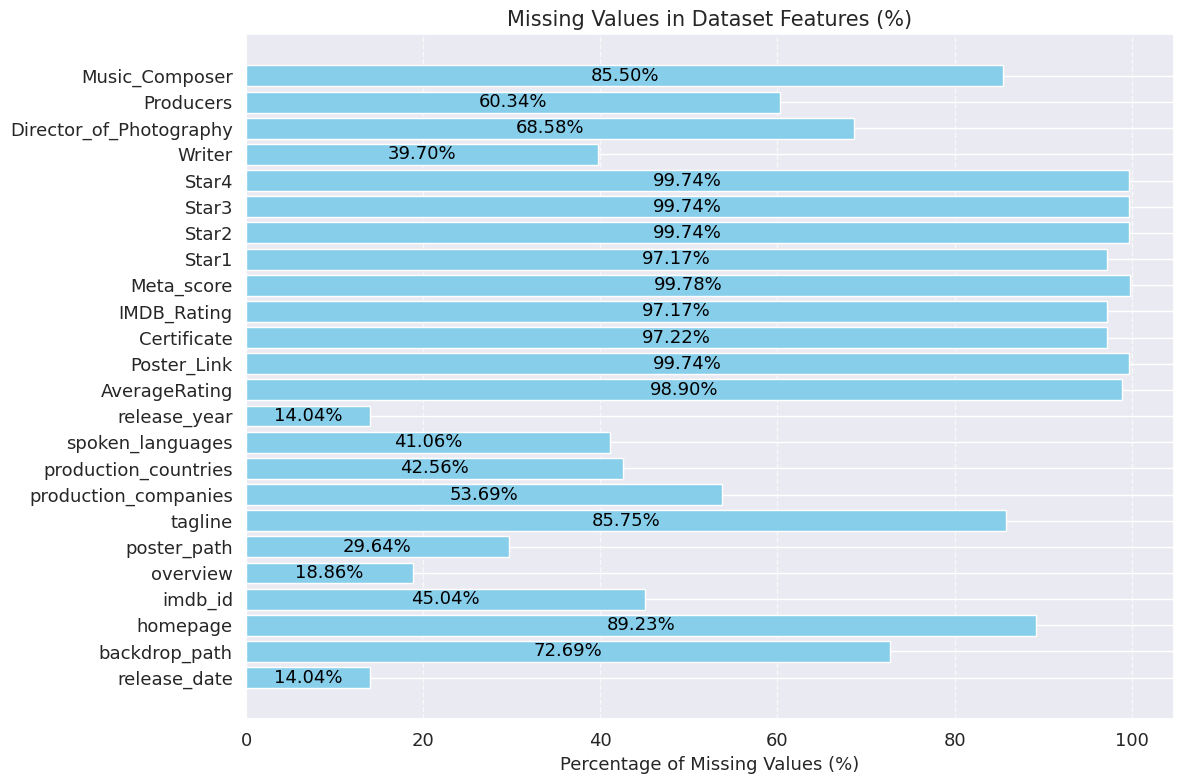

In [ ]:
summary = pd.DataFrame({
    "Data Type": df.dtypes,  # Kiểu dữ liệu của mỗi cột
    "Missing (%)": df.isnull().mean() * 100,  # Tỷ lệ phần trăm giá trị thiếu
    "Unique Values": df.nunique(),  # Số lượng giá trị duy nhất trong mỗi cột
})

# Vẽ biểu đồ barh cho các giá trị thiếu (% thiếu)
plt.figure(figsize=(12, 8))  # Giảm chiều rộng của biểu đồ để chữ không bị tràn ra
missing_values = df.isnull().mean() * 100  # Tính tỷ lệ phần trăm giá trị thiếu
missing_values = missing_values[missing_values > 0]  # Chỉ lấy các cột có giá trị thiếu

# Vẽ biểu đồ cột ngang
bars = plt.barh(missing_values.index, missing_values.values, color='skyblue')
plt.title('Missing Values in Dataset Features (%)', fontsize=15)
plt.xlabel('Percentage of Missing Values (%)', fontsize=13)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Hiển thị tỷ lệ phần trăm ngay giữa mỗi cột
for i, bar in enumerate(bars):
    # Tính vị trí trung tâm của cột
    width = bar.get_width()
    plt.text(width / 2, bar.get_y() + bar.get_height() / 2, f'{width:.2f}%',
             color='black', ha='center', va='center', fontsize=13)

# Tăng cỡ của các nhãn trục x và y để dễ đọc
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# Tự động điều chỉnh bố cục để các nhãn không bị cắt
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()

Loại bỏ các cột có tỉ lệ dữ liệu bị thiếu trên 50% nhưng em sẽ giữ lại cột production_companies để dùng tạo bảng trong DataWarehouse

In [ ]:
missing_values = df.isnull().mean() * 100

# Xác định các cột cần loại bỏ do thiếu trên 50%, trừ 'production_companies'
columns_to_drop_due_to_missing = missing_values[(missing_values > 50) & (missing_values.index != 'production_companies')].index

df = df.drop(columns=columns_to_drop_due_to_missing, errors='ignore')

print(f"Kích thước dữ liệu sau khi loại bỏ: {df.shape}")
print("Thông tin các cột còn lại trong bộ dữ liệu:")
print(df.info())

Kích thước dữ liệu sau khi loại bỏ: (1072255, 27)
Thông tin các cột còn lại trong bộ dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1072255 entries, 0 to 1072254
Data columns (total 27 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   id                     1072255 non-null  int64         
 1   title                  1072255 non-null  object        
 2   vote_average           1072255 non-null  float64       
 3   vote_count             1072255 non-null  int64         
 4   status                 1072255 non-null  object        
 5   release_date           921699 non-null   datetime64[ns]
 6   revenue                1072255 non-null  int64         
 7   runtime                1072255 non-null  int64         
 8   adult                  1072255 non-null  bool          
 9   budget                 1072255 non-null  int64         
 10  imdb_id                589364 non-null   object        


In [ ]:
df.duplicated(subset=['id', 'title']).sum()

616

In [ ]:
df = df.drop_duplicates(subset=['id'])
df = df.drop_duplicates(subset=['title'], keep='first')
df.shape

(921342, 27)

In [ ]:
max_length = 255
condition = True

for col in df.select_dtypes(include='object').columns:
    condition &= df[col].apply(lambda x: len(str(x)) <= max_length)

df = df[condition]
print(f"Removed {len(df) - len(df)} rows with length greater than {max_length} in any column.")

Removed 0 rows with length greater than 255 in any column.


## Xóa các dòng không cần thiết

In [ ]:
columns_to_drop = ['poster_path', 'overview', 'original_title','all_combined_keywords','keywords','overview_sentiment','Cast_list','Writer','adult','release_year']
df = df.drop(columns=columns_to_drop, errors='ignore')
df = df.dropna()
df = df.drop_duplicates()
df.shape

(82527, 17)

Bộ dữ liệu df chứa thông tin các phim từ năm 2000 trở đi sẽ được dùng để tạo datawarehouse

In [ ]:
df = df[df['release_date'].dt.year >= 2000]
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37310 entries, 56 to 1072251
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    37310 non-null  int64         
 1   title                 37310 non-null  object        
 2   vote_average          37310 non-null  float64       
 3   vote_count            37310 non-null  int64         
 4   status                37310 non-null  object        
 5   release_date          37310 non-null  datetime64[ns]
 6   revenue               37310 non-null  int64         
 7   runtime               37310 non-null  int64         
 8   budget                37310 non-null  int64         
 9   imdb_id               37310 non-null  object        
 10  original_language     37310 non-null  object        
 11  popularity            37310 non-null  float64       
 12  production_companies  37310 non-null  object        
 13  production_countri

## Kiểm tra giá tị categorical của các trường trong file

In [ ]:
def plot_categorical_distribution(df_to_check, field_name):
    value_counts = df[field_name].value_counts()
    plt.figure(figsize=(10, 8))

    ax = sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:,.0f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom',
                    fontsize=12, color='black',
                    xytext=(0, 5), textcoords='offset points')

    plt.title(f'Distribution of {field_name}')
    plt.xlabel(field_name)
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

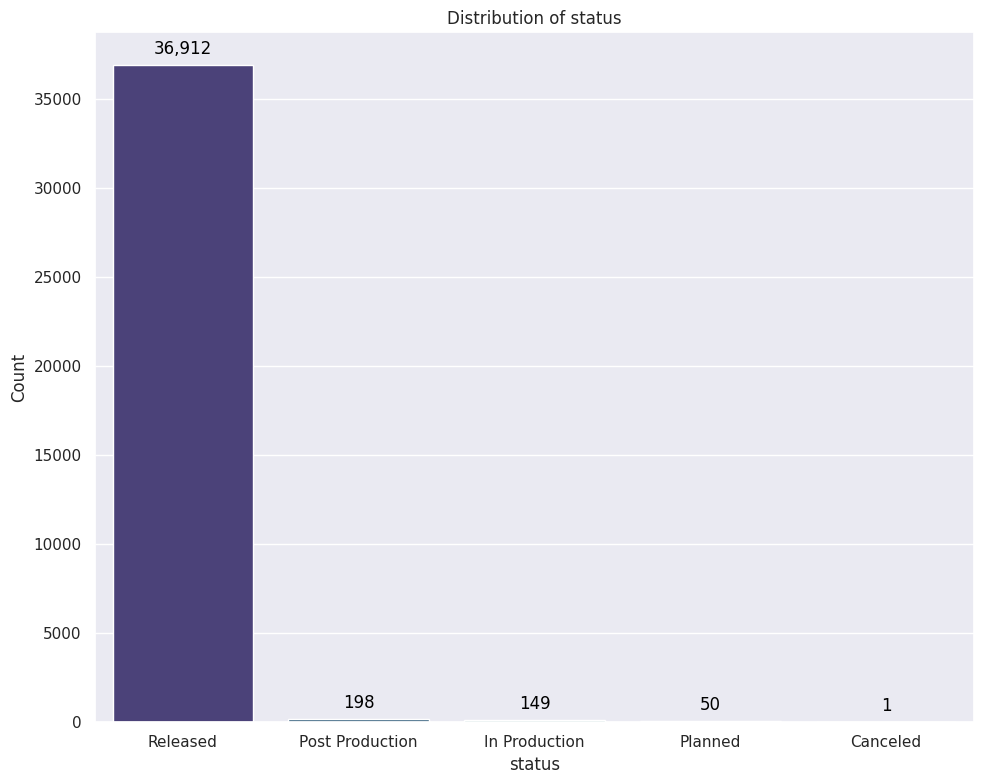

In [ ]:
plot_categorical_distribution(df,'status')

## Tính toán các thống kê cơ bản cho các trường có thể tính toán được (dữ liệu dạng số)

In [ ]:
columns_to_analyze = ['vote_average', 'vote_count', 'revenue', 'runtime', 'budget','popularity']

statistics = df[columns_to_analyze].describe()

print(statistics)

       vote_average    vote_count       revenue       runtime        budget  \
count  37310.000000  37310.000000  3.731000e+04  37310.000000  3.731000e+04   
mean       3.664928     26.234629  7.106275e+05     64.657438  3.970568e+05   
std        3.245580    231.097627  1.729701e+07     52.229828  5.674112e+06   
min        0.000000      0.000000  0.000000e+00      0.000000  0.000000e+00   
25%        0.000000      0.000000  0.000000e+00     10.000000  0.000000e+00   
50%        4.700000      1.000000  0.000000e+00     80.000000  0.000000e+00   
75%        6.400000      6.000000  0.000000e+00     99.000000  0.000000e+00   
max       10.000000  18352.000000  2.068224e+09    993.000000  5.000000e+08   

         popularity  
count  37310.000000  
mean       2.208475  
std        9.061680  
min        0.000000  
25%        0.600000  
50%        0.863000  
75%        1.841000  
max      961.212000  


In [ ]:
df.to_csv('Data_Movie_TMDB-IMDB.csv', index=False)

# Basic Exploratory Data Analysis

In [6]:
df_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1072255 entries, 0 to 1072254
Data columns (total 42 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id                       1072255 non-null  int64  
 1   title                    1072255 non-null  object 
 2   vote_average             1072255 non-null  float64
 3   vote_count               1072255 non-null  int64  
 4   status                   1072255 non-null  object 
 5   release_date             921699 non-null   object 
 6   revenue                  1072255 non-null  int64  
 7   runtime                  1072255 non-null  int64  
 8   adult                    1072255 non-null  bool   
 9   backdrop_path            292826 non-null   object 
 10  budget                   1072255 non-null  int64  
 11  homepage                 115519 non-null   object 
 12  imdb_id                  589364 non-null   object 
 13  original_language        1072255 non-null 

In [7]:
df_rate.dropna(thresh=int(0.5*len(df_rate)), axis=1, inplace=True)  # Loại bỏ các cột thiếu hơn 50% dữ liệu

# Chuyển đổi dữ liệu sang dạng phù hợp
df_rate['revenue'] = df_rate['revenue'].astype(float)
df_rate['budget'] = df_rate['budget'].astype(float)

df_rate['release_date'] = pd.to_datetime(df_rate['release_date'], errors='coerce')

# Loại bỏ các dòng có NaN hoặc giá trị vô hạn trong 'release_year'
df_rate = df_rate[~df_rate['release_year'].isna() & ~df_rate['release_year'].isin([np.inf, -np.inf])]
df_rate['release_year'] = df_rate['release_year'].astype(int)

print(df_rate.info())

<class 'pandas.core.frame.DataFrame'>
Index: 921699 entries, 0 to 1072254
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   id                     921699 non-null  int64         
 1   title                  921699 non-null  object        
 2   vote_average           921699 non-null  float64       
 3   vote_count             921699 non-null  int64         
 4   status                 921699 non-null  object        
 5   release_date           921699 non-null  datetime64[ns]
 6   revenue                921699 non-null  float64       
 7   runtime                921699 non-null  int64         
 8   adult                  921699 non-null  bool          
 9   budget                 921699 non-null  float64       
 10  imdb_id                548153 non-null  object        
 11  original_language      921699 non-null  object        
 12  original_title         921699 non-null  object  

# Feature Engineering

In [8]:
columns2drop = ['imdb_id','Writer','Director','Cast_list','all_combined_keywords'

               ,'original_title','overview','poster_path','keywords','id']

df_rate = df_rate.drop(columns=columns2drop, errors='ignore')

df_rate.info()

<class 'pandas.core.frame.DataFrame'>
Index: 921699 entries, 0 to 1072254
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   title                 921699 non-null  object        
 1   vote_average          921699 non-null  float64       
 2   vote_count            921699 non-null  int64         
 3   status                921699 non-null  object        
 4   release_date          921699 non-null  datetime64[ns]
 5   revenue               921699 non-null  float64       
 6   runtime               921699 non-null  int64         
 7   adult                 921699 non-null  bool          
 8   budget                921699 non-null  float64       
 9   original_language     921699 non-null  object        
 10  popularity            921699 non-null  float64       
 11  production_countries  594202 non-null  object        
 12  spoken_languages      597942 non-null  object        
 13  rel

## Revenue

In [9]:
zero_revenue = df_rate[df_rate['revenue'] == 0].shape[0] / df_rate.shape[0] * 100
print(f"Phim có doanh thu là 0: {zero_revenue:.2f}%")

Phim có doanh thu là 0: 97.99%


Các bộ phim chưa phát hành (trạng thái không phải là 'Released') sẽ được giữ lại bất kể doanh thu là bao nhiêu (doanh thu có thể là 0 hoặc lớn hơn 0).
Các bộ phim đã phát hành phải có doanh thu khác 0 (doanh thu không thể là 0 nếu phim đã phát hành).

In [10]:
df_rate = df_rate[((df_rate['revenue'] >= 0) & (df_rate['status'] != 'Released'))
            | ((df_rate['revenue'] != 0) & (df_rate['status'] == 'Released'))]
print(f"Số dòng dữ liệu sau khi xử lý dữ liệu ngoai lai: {df_rate.shape[0]}")

Số dòng dữ liệu sau khi xử lý dữ liệu ngoai lai: 24861


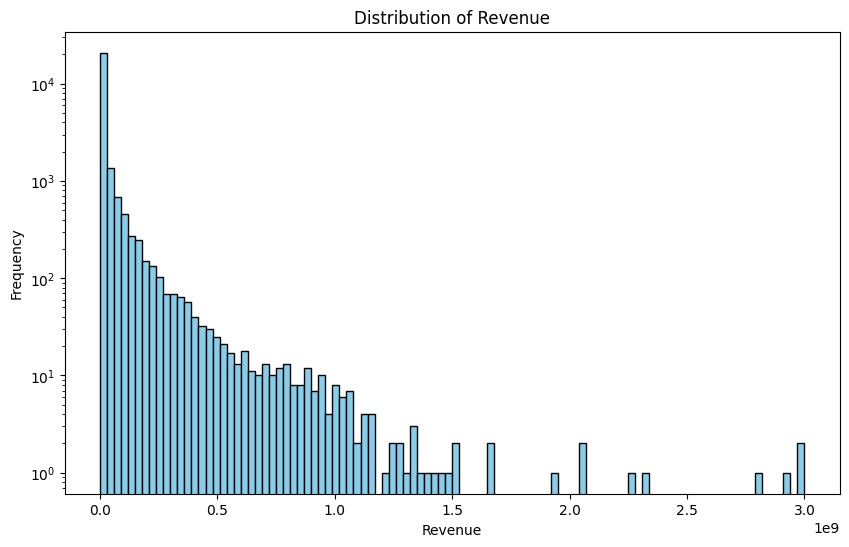

In [11]:
plt.figure(figsize=(10, 6))
plt.hist(df_rate['revenue'], bins=100, color='skyblue', edgecolor='black')
plt.yscale('log')  # Set y-axis to log scale
plt.title('Distribution of Revenue')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.show()

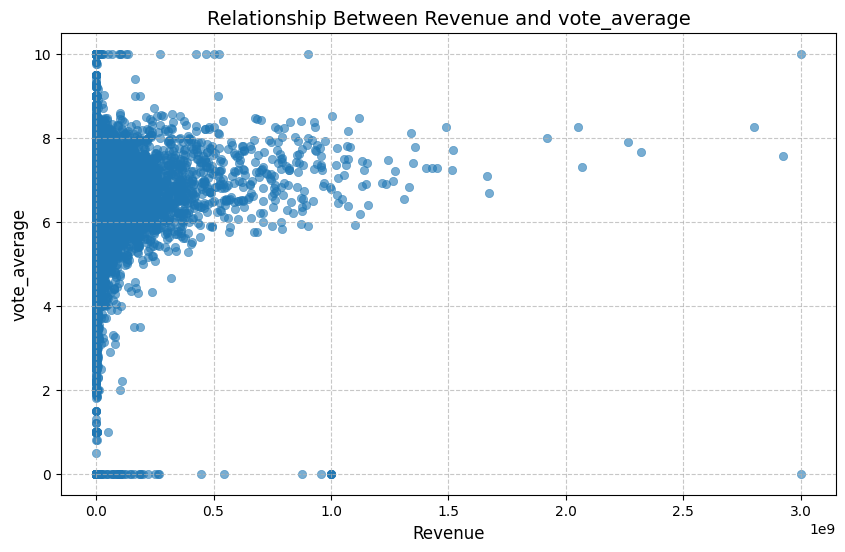

In [12]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_rate, x='revenue', y='vote_average', alpha=0.6, edgecolor=None)
plt.title("Relationship Between Revenue and vote_average", fontsize=14)
plt.xlabel("Revenue", fontsize=12)
plt.ylabel("vote_average", fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.show()

## vote_average

In [13]:
print(f"Phim có rating là 0: {(df_rate[(df_rate['vote_average'] == 0)]).shape[0]}")

Phim có rating là 0: 8411


In [14]:
df_rate = df_rate[df_rate['vote_average'] != 0]
print(f"Số dòng dữ liệu sau khi loại bỏ các phim có đánh giá là 0: {df_rate.shape[0]}")

Số dòng dữ liệu sau khi loại bỏ các phim có đánh giá là 0: 16450


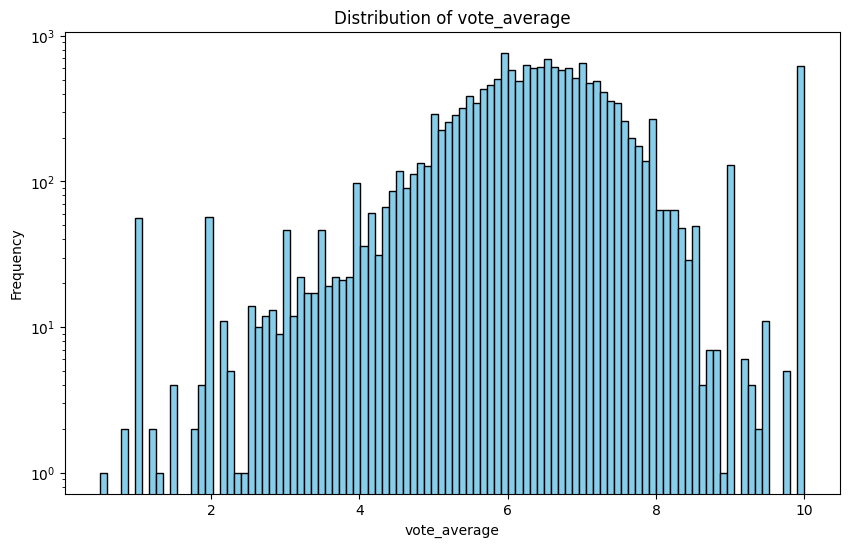

In [15]:
plt.figure(figsize=(10,6))
plt.hist(df_rate['vote_average'], bins=100, color='skyblue', edgecolor='black')
plt.yscale('log')
plt.title('Distribution of vote_average')
plt.xlabel('vote_average')
plt.ylabel('Frequency')
plt.show()

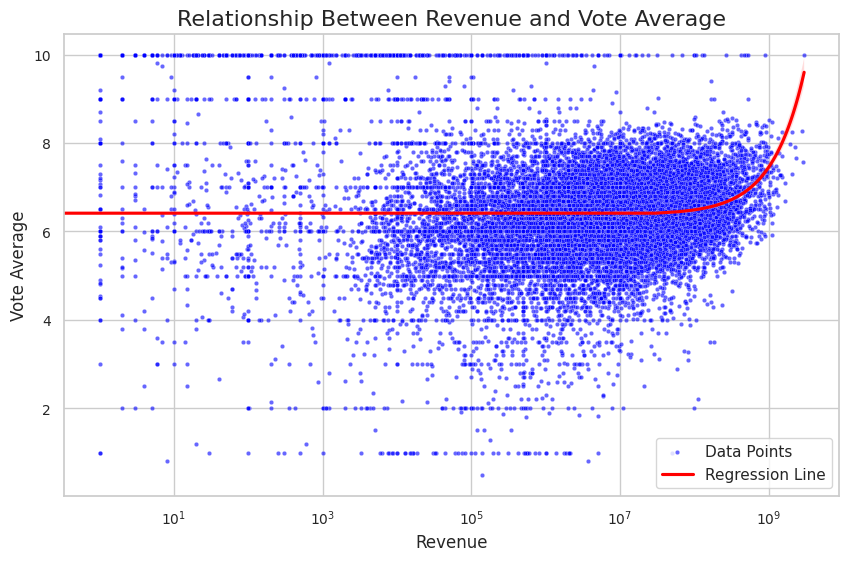

In [16]:
sns.set_theme(style="whitegrid")

# Creating a scatter plot with transparency and a fitted regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_rate, x='revenue', y='vote_average', alpha=0.6, color='blue', s=10, label="Data Points")
sns.regplot(data=df_rate, x='revenue', y='vote_average', scatter=False, color='red', label="Regression Line")

# Adding titles and labels
plt.title("Relationship Between Revenue and Vote Average", fontsize=16)
plt.xlabel("Revenue", fontsize=12)
plt.ylabel("Vote Average", fontsize=12)
plt.legend()

# Setting the x-axis to log scale for better visualization of the spread
plt.xscale('log')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.show()

## runtime

In [17]:
print(f"Phim có thời lượng là 0: {df_rate[df_rate['runtime'] == 0].shape[0]}")
print(f"Phim có thời lượng là 5 tiếng: {df_rate[df_rate['runtime'] > 300].shape[0]}")

Phim có thời lượng là 0: 461
Phim có thời lượng là 5 tiếng: 16


Thay thế các phim có thời lường bằng 0 bằng trung vị và giữ lại các bộ phim có thời lượng từ 45p đến 300p

In [18]:
median_runtime = df_rate['runtime'][df_rate['runtime'] > 0].median()
df_rate['runtime'] = df_rate['runtime'].replace(0, median_runtime)

df_rate = df_rate[(df_rate['runtime'] >= 45) & (df_rate['runtime'] < 300)]

print(f"Phim có thời lượng từ 45p đến 300p: {df_rate.shape[0]}")

Phim có thời lượng từ 45p đến 300p: 15928


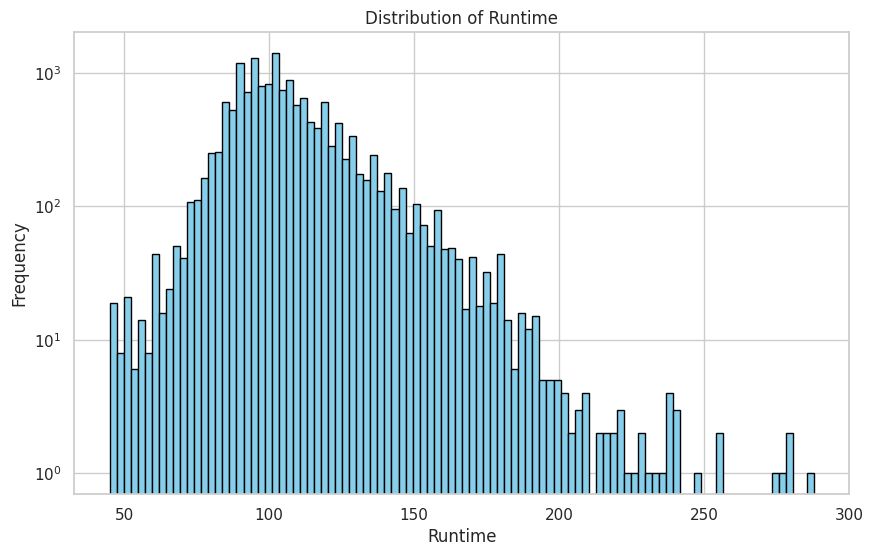

In [19]:
plt.figure(figsize=(10, 6))
plt.hist(df_rate['runtime'], bins=100, color='skyblue', edgecolor='black')
plt.yscale('log')
plt.title('Distribution of Runtime')
plt.xlabel('Runtime')
plt.ylabel('Frequency')
plt.show()

Text(0.5, 1.0, 'Log vote_average vs log runtime')

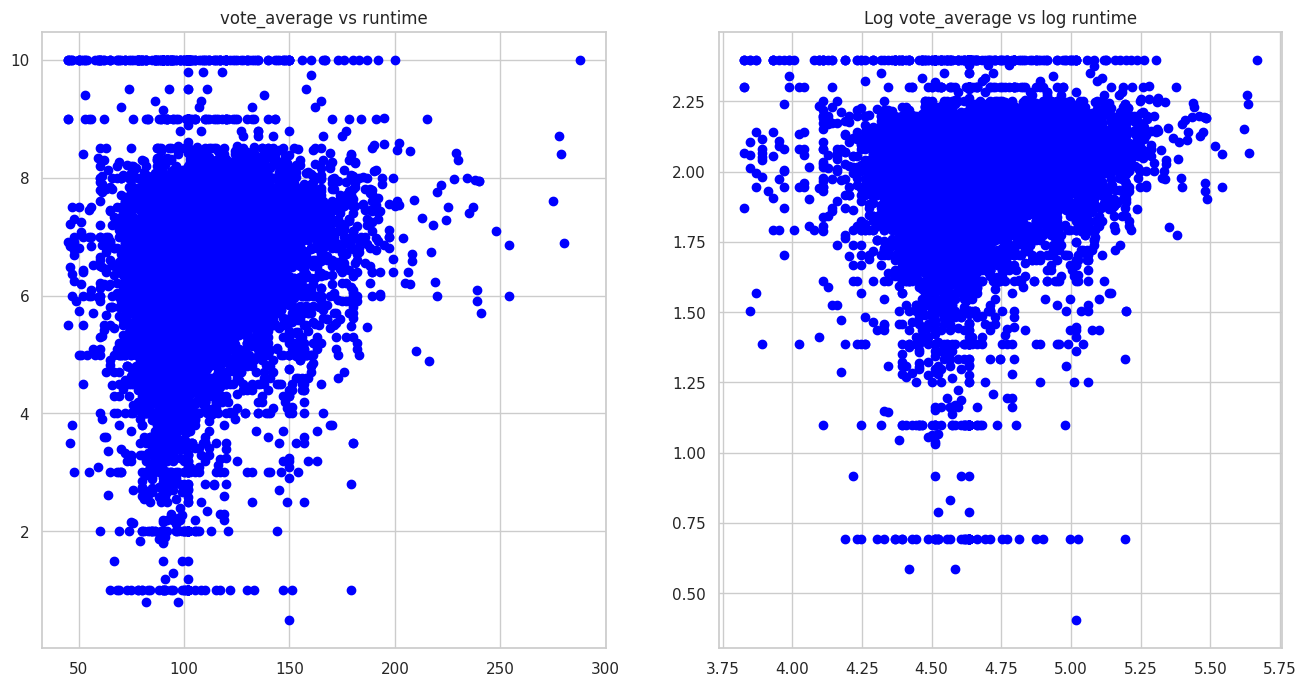

In [20]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(df_rate['runtime'], df_rate['vote_average'], color='blue')
plt.title('vote_average vs runtime')
plt.subplot(1, 2, 2)
plt.scatter(np.log1p(df_rate['runtime']), np.log1p(df_rate['vote_average']), color='blue')
plt.title('Log vote_average vs log runtime')

## title

In [21]:
df_rate['title_length'] = df_rate['title'].apply(len)
print(df_rate['title_length'].describe())

count    15928.000000
mean        15.888749
std          9.569325
min          1.000000
25%         10.000000
50%         14.000000
75%         20.000000
max        213.000000
Name: title_length, dtype: float64


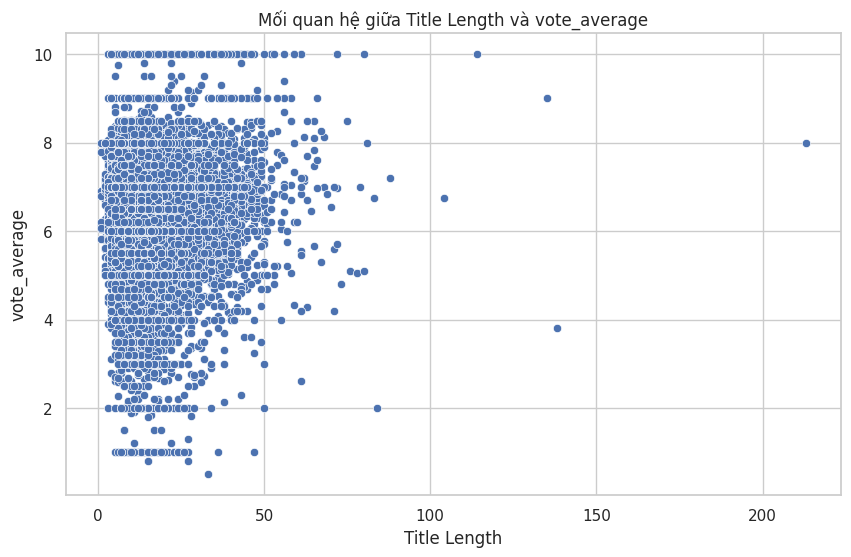

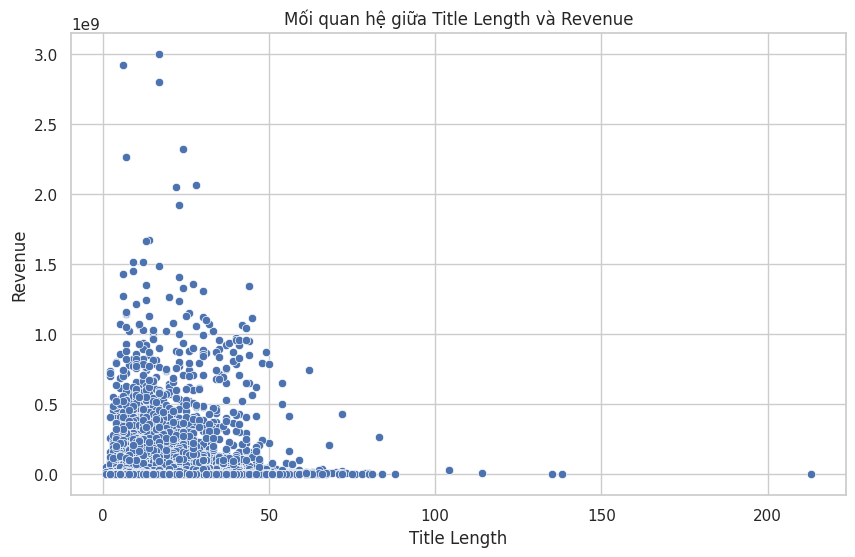

In [22]:
# Biểu đồ phân tán giữa title_length và vote_average
plt.figure(figsize=(10, 6))
sns.scatterplot(x='title_length', y='vote_average', data=df_rate)
plt.title("Mối quan hệ giữa Title Length và vote_average")
plt.xlabel("Title Length")
plt.ylabel("vote_average")
plt.show()

# Biểu đồ phân tán giữa title_length và revenue
plt.figure(figsize=(10, 6))
sns.scatterplot(x='title_length', y='revenue', data=df_rate)
plt.title("Mối quan hệ giữa Title Length và Revenue")
plt.xlabel("Title Length")
plt.ylabel("Revenue")
plt.show()

## budget

In [23]:
zero_bugdet = df_rate[df_rate['budget'] == 0].shape[0] / df_rate.shape[0] * 100
print(f"Phim có kinh phí là 0: {zero_bugdet:.2f}%")

Phim có kinh phí là 0: 36.05%


In [24]:
median_budget = df_rate.loc[df_rate['budget'] > 0, 'budget'].median()

# Thay thế giá trị 0 trong cột 'budget' bằng giá trị trung vị
df_rate['re_budget'] = df_rate['budget'].replace(0, median_budget)

print(f"Số dòng dữ liệu sau khi thay thế các phim có kinh phí bằng 0 bằng trung vị: {df_rate.shape[0]}")

Số dòng dữ liệu sau khi thay thế các phim có kinh phí bằng 0 bằng trung vị: 15928


In [25]:
budget_10k = df_rate[df_rate['budget'] < 10000].shape[0]
print(f"Phim có kinh phí dưới 10k: {budget_10k}")

Phim có kinh phí dưới 10k: 6309


In [26]:
# Gán NaN cho các dòng có budget <= 10000
df_rate.loc[df_rate['budget'] <= 10000, 'budget'] = np.nan

# Sử dụng KNNImputer để điền giá trị NaN trong cột 're_budget' dựa trên các cột khác
imputer = KNNImputer(n_neighbors=5)
df_rate['re_budget'] = imputer.fit_transform(df_rate[['title_length', 'vote_average', 'vote_count', 'runtime']])

In [27]:
# Điền lại giá trị trung vị cho các dòng có budget < 10000
median = df_rate.loc[df_rate['budget'] >= 10000, 'budget'].median()
df_rate["re_budget"] = df_rate["budget"].mask(df_rate["budget"] < 10000, median)

print(df_rate[['budget', 're_budget']].head())

        budget    re_budget
0  160000000.0  160000000.0
1  165000000.0  165000000.0
2  185000000.0  185000000.0
3  237000000.0  237000000.0
4  220000000.0  220000000.0


In [28]:
df_rate['re_budget'].isnull().sum()

6379

In [29]:
df_rate.drop(columns=['budget'], inplace=True)
df_rate.rename(columns={'re_budget': 'budget'}, inplace=True)

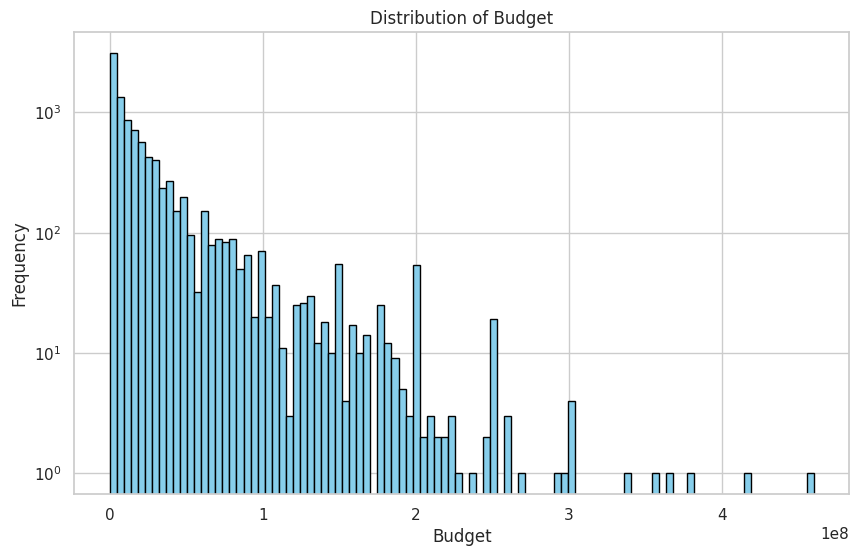

In [30]:
plt.figure(figsize=(10, 6))
plt.hist(df_rate['budget'], bins=100, color='skyblue', edgecolor='black')
plt.yscale('log')  # Set y-axis to log scale
plt.title('Distribution of Budget')
plt.xlabel('Budget')
plt.ylabel('Frequency')
plt.show()

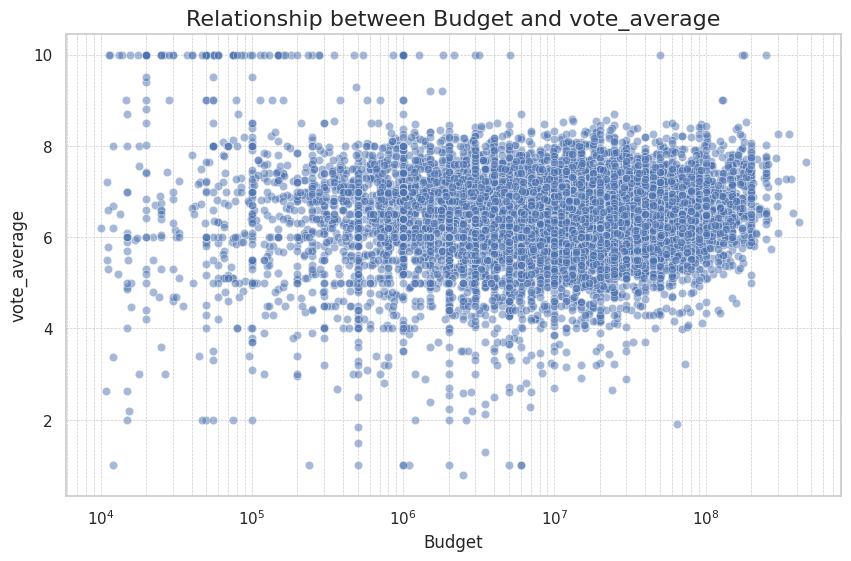

In [31]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_rate, x='budget', y='vote_average', alpha=0.5)
plt.title('Relationship between Budget and vote_average', fontsize=16)
plt.xlabel('Budget', fontsize=12)
plt.ylabel('vote_average', fontsize=12)
plt.xscale('log')  # Using log scale for better visualization if budget has large variation
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()

## popularity

In [32]:
df_rate['popularity'].describe()

,popularity
count,15928.000000
mean,15.217529
std,50.118595
min,0.000000
25%,3.750000
50%,9.982000
75%,16.870000
max,2994.357000


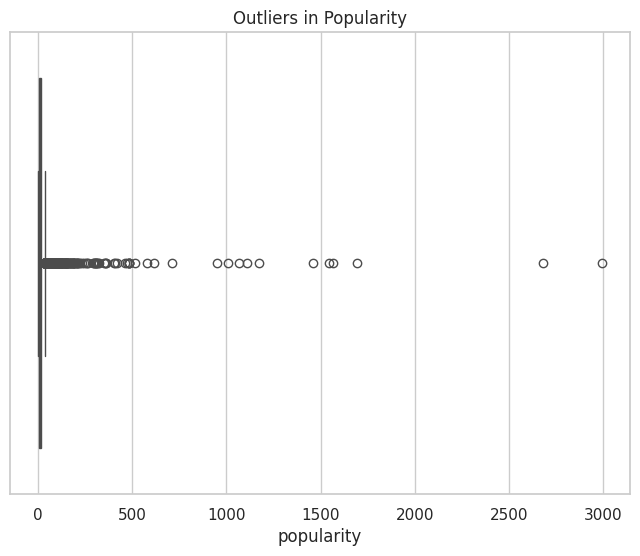

In [33]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_rate['popularity'])
plt.title('Outliers in Popularity')
plt.show()

## vote_count

In [34]:
df_rate['vote_count'].describe()

,vote_count
count,15928.000000
mean,1026.761866
std,2460.212456
min,0.000000
25%,26.000000
50%,174.000000
75%,823.000000
max,34495.000000


In [35]:
print(f"Phim có vote và rating đều là 0: {df_rate[((df_rate['vote_count'] == 0) & (df_rate['vote_average'] == 0))].shape[0]}")
print(f"Phim có vote là 0: {df_rate[(df_rate['vote_count'] == 0)].shape[0]}")

Phim có vote và rating đều là 0: 0
Phim có vote là 0: 3


In [36]:
df_rate = df_rate[df_rate['vote_count'] > 0] # giữ lại các phim có lượt vote lớn hơn 0

print(f"Số lượng phim có số vote lớn hơn không 0: {df_rate.shape[0]}")

Số lượng phim có số vote lớn hơn không 0: 15925


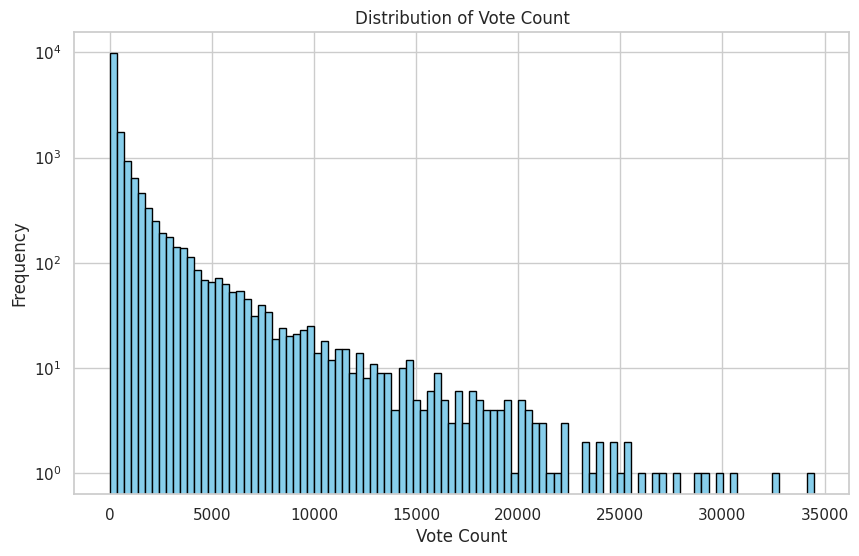

In [37]:
plt.figure(figsize=(10,6))
plt.hist(df_rate['vote_count'], bins=100, color='skyblue', edgecolor='black')
plt.yscale('log')  # Set the y-axis to log scale
plt.title('Distribution of Vote Count')
plt.xlabel('Vote Count')
plt.ylabel('Frequency')
plt.show()

## overview_sentiment

In [38]:
df_rate['overview_sentiment'].describe()

,overview_sentiment
count,15925.000000
mean,0.048135
std,0.217973
min,-1.000000
25%,-0.055051
50%,0.028472
75%,0.166667
max,1.000000


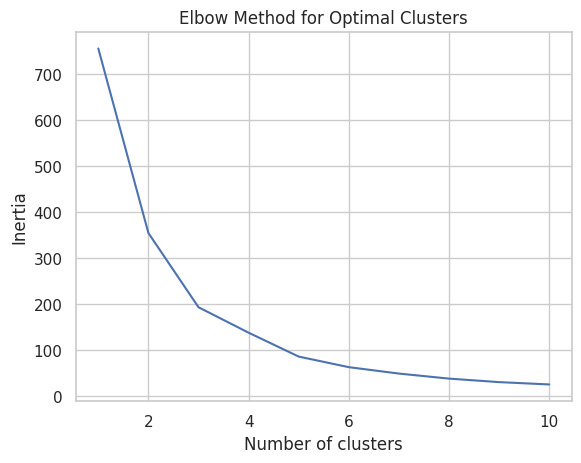

   overview_sentiment  sentiment_cluster
0           -0.011111                  2
1            0.045455                  2
2            0.025000                  2
3            0.041667                  2
4            0.025000                  2


In [39]:
X = df_rate[['overview_sentiment']]

# Find the optimal number of clusters using the elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the inertia to find the elbow
plt.plot(range(1, 11), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

# Based on the elbow plot, assume the optimal number of clusters is 3
kmeans = KMeans(n_clusters=3, random_state=42)
df_rate['sentiment_cluster'] = kmeans.fit_predict(X)

# Check the first few rows with the cluster labels
print(df_rate[['overview_sentiment', 'sentiment_cluster']].head())

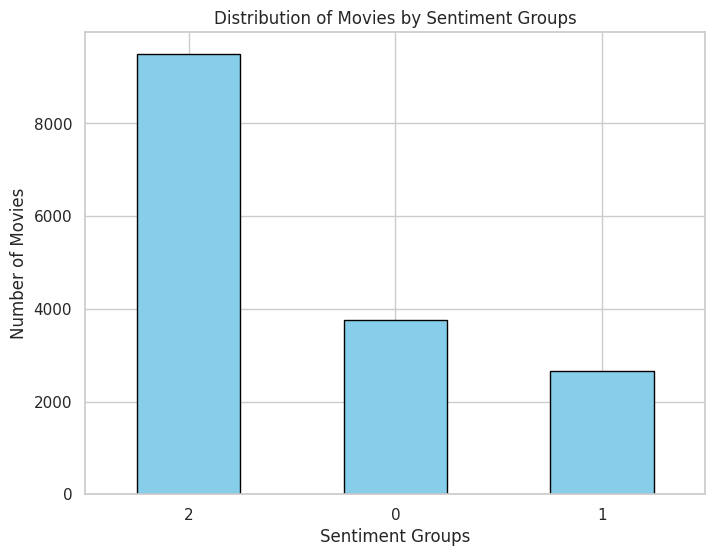

In [40]:
sentiment_group_counts = df_rate['sentiment_cluster'].value_counts()

plt.figure(figsize=(8, 6))
sentiment_group_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Movies by Sentiment Groups')
plt.xlabel('Sentiment Groups')
plt.ylabel('Number of Movies')
plt.xticks(rotation=0)
plt.show()

In [41]:
silhouette_avg = silhouette_score(X, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

print(f"Inertia: {kmeans.inertia_}")

db_index = davies_bouldin_score(X, kmeans.labels_)
print(f"Davies-Bouldin Index: {db_index}")

cluster_means = df_rate.groupby('sentiment_cluster')['overview_sentiment'].mean()
print(f"cluster_means: {cluster_means}")

Silhouette Score: 0.5559049388829899
Inertia: 193.51950334353415
Davies-Bouldin Index: 0.5783751633350815
cluster_means: sentiment_cluster
0    0.323889
1   -0.271971
2    0.028858
Name: overview_sentiment, dtype: float64


## status

In [42]:
df_rate['status'].value_counts(normalize=True) * 100

,proportion
status,
Released,100.0


Vì status chỉ có 1 giá trị là 'Released' nên cột này không có giá trị phân loại. Do đó em sẽ drop cột này

In [43]:
df_rate = df_rate.drop(columns ='status')

## adult

In [44]:
df_rate['adult'] = df_rate['adult'].map(lambda x: 1 if (x == True) else 0)

print(df_rate['adult'].value_counts())

adult
0    15894
1       31
Name: count, dtype: int64


## production_countries

In [45]:
df_rate['production_countries'].isnull().sum()

471

In [46]:
df_rate['production_countries'] = df_rate['production_countries'].fillna('Unknown')

In [47]:
df_rate['re_production_countries'] = df_rate['production_countries'].apply(lambda x: [genre.strip() for genre in x.split(',')])

<Axes: >

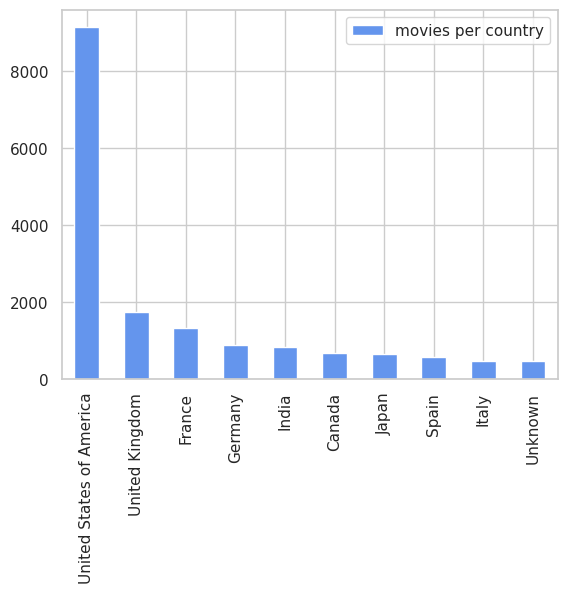

In [48]:
countriesDict = {}
for element in df_rate["re_production_countries"].values:
    for country in element:
        if country not in countriesDict:
            countriesDict[country] = 1
        else:
            countriesDict[country] += 1

countries_train = pd.DataFrame.from_dict(countriesDict, orient='index', columns=["movies per country"])
countries_train.sort_values(by="movies per country", ascending=False).head(10).plot.bar(color='cornflowerblue')

In [49]:
# Xử lý cột số lượng quốc gia sản xuất
df_rate['num_production_countries'] = df_rate.re_production_countries.apply(lambda x: len(x) if x[0] != 'None' else 0)

# Tạo cột kiểm tra phim có được sản xuất ở Mỹ hay không
df_rate['is_produced_in_US'] = df_rate['production_countries'].apply(lambda x: 'United States of America' in x)
df_rate['is_produced_in_US'] = df_rate['is_produced_in_US'].astype(int)

print(df_rate[['production_countries', 'num_production_countries', 'is_produced_in_US']].head())

                       production_countries  num_production_countries  \
0  United Kingdom, United States of America                         2   
1  United Kingdom, United States of America                         2   
2  United Kingdom, United States of America                         2   
3  United States of America, United Kingdom                         2   
4                  United States of America                         1   

   is_produced_in_US  
0                  1  
1                  1  
2                  1  
3                  1  
4                  1  


## spoken_languages

In [50]:
df_rate['spoken_languages'].isnull().sum()

269

In [51]:
df_rate['spoken_languages'] = df_rate['spoken_languages'].fillna('')

In [52]:
df_rate['re_spoken_languages'] = df_rate['spoken_languages'].apply(lambda x: [genre.strip() for genre in x.split(',')])

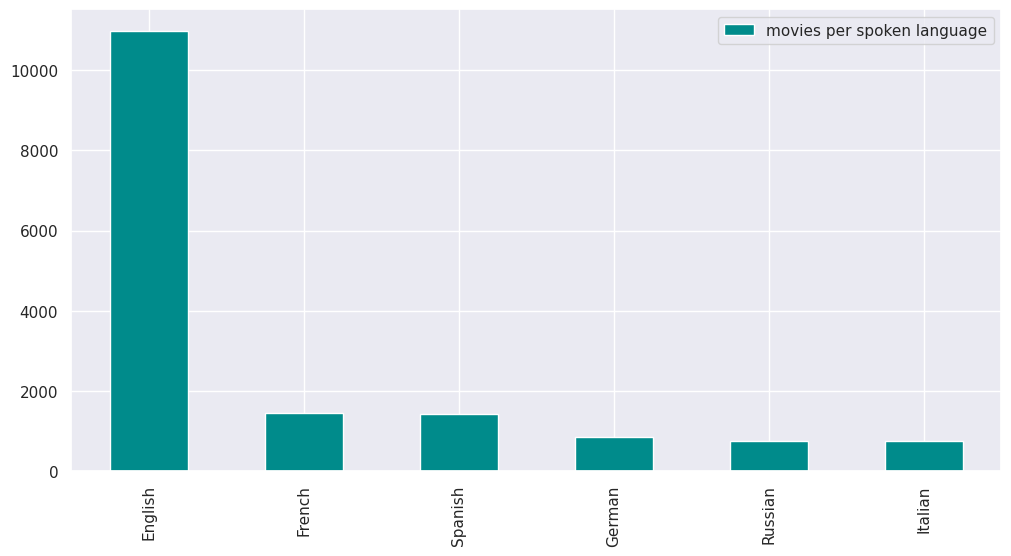

In [53]:
languagesDict = {}
for element in df_rate["re_spoken_languages"].values:
    for name in element:
        if name not in languagesDict:
            languagesDict[name] = 1
        else:
            languagesDict[name] += 1

sns.set(rc={'figure.figsize':(12,6)})


languages_train = pd.DataFrame.from_dict(languagesDict, orient='index', columns=["movies per spoken language"])
languages_train.sort_values(by="movies per spoken language", ascending=False).head(6).plot.bar(color='darkcyan')
languages_train.columns = ["number_of_languages"]

In [54]:
df_rate['num_spoken_languages'] = df_rate.re_spoken_languages.apply(lambda x: len(x) if x[0] != '' else 0)

df_rate['is_spoken_in_English'] = df_rate['spoken_languages'].apply(lambda x: 1 if 'English' in x else 0)

print(df_rate[['spoken_languages', 'num_spoken_languages', 'is_spoken_in_English']].head())

                     spoken_languages  num_spoken_languages  \
0  English, French, Japanese, Swahili                     4   
1                             English                     1   
2                   English, Mandarin                     2   
3                    English, Spanish                     2   
4             English, Hindi, Russian                     3   

   is_spoken_in_English  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1  


## original_language

In [55]:
print("Counts of each original language:")
print(df_rate['original_language'].value_counts()[:10])

Counts of each original language:
original_language
en    10497
fr      633
es      620
ja      464
ru      416
hi      394
zh      375
it      274
de      261
ko      243
Name: count, dtype: int64


In [56]:
language_threshold = 500

# Xác định các ngôn ngữ phổ biến
popular_languages = df_rate['original_language'].value_counts()
popular_languages = popular_languages[popular_languages >= language_threshold].index.tolist()

# Tạo One-Hot Encoding cho các ngôn ngữ phổ biến
one_hot_encoded = pd.get_dummies(df_rate['original_language'], prefix='lang')

# Chỉ giữ lại các cột của các ngôn ngữ phổ biến
one_hot_encoded = one_hot_encoded[['lang_' + lang for lang in popular_languages if 'lang_' + lang in one_hot_encoded.columns]].astype(int)

# Gắn One-Hot Encoding vào DataFrame gốc
df_rate = pd.concat([df_rate, one_hot_encoded], axis=1)

print(df_rate.info())

<class 'pandas.core.frame.DataFrame'>
Index: 15925 entries, 0 to 348696
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   title                     15925 non-null  object        
 1   vote_average              15925 non-null  float64       
 2   vote_count                15925 non-null  int64         
 3   release_date              15925 non-null  datetime64[ns]
 4   revenue                   15925 non-null  float64       
 5   runtime                   15925 non-null  int64         
 6   adult                     15925 non-null  int64         
 7   original_language         15925 non-null  object        
 8   popularity                15925 non-null  float64       
 9   production_countries      15925 non-null  object        
 10  spoken_languages          15925 non-null  object        
 11  release_year              15925 non-null  int64         
 12  genres_list           

## release_date

In [57]:
df_rate = df_rate
df_rate.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15925 entries, 0 to 348696
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   title                     15925 non-null  object        
 1   vote_average              15925 non-null  float64       
 2   vote_count                15925 non-null  int64         
 3   release_date              15925 non-null  datetime64[ns]
 4   revenue                   15925 non-null  float64       
 5   runtime                   15925 non-null  int64         
 6   adult                     15925 non-null  int64         
 7   original_language         15925 non-null  object        
 8   popularity                15925 non-null  float64       
 9   production_countries      15925 non-null  object        
 10  spoken_languages          15925 non-null  object        
 11  release_year              15925 non-null  int64         
 12  genres_list           

In [58]:
num_unique_years = df_rate['release_year'].nunique()

print(f"Số lượng năm có trong dữ liệu: {num_unique_years}")

Số lượng năm có trong dữ liệu: 112


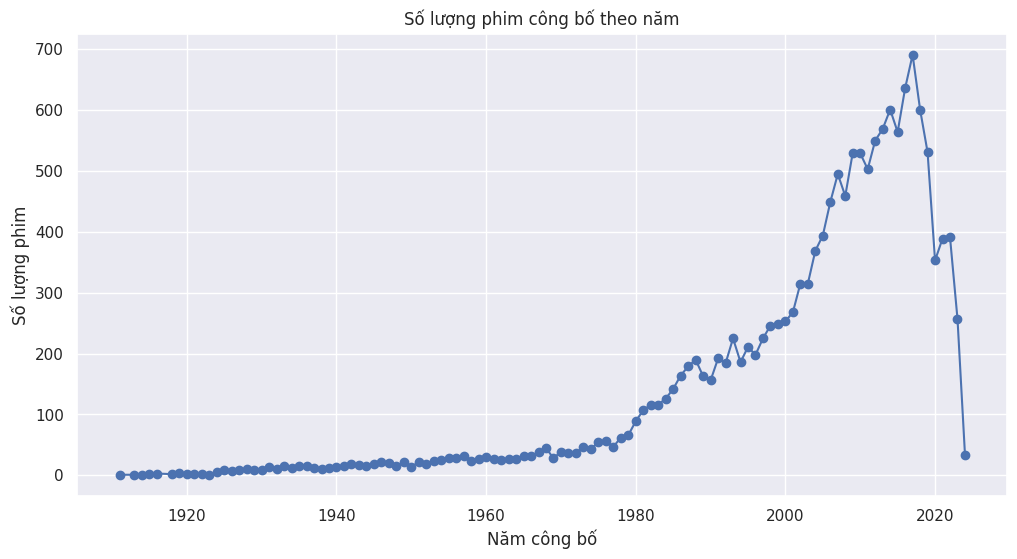

In [59]:
# Tính số lượng phim cho mỗi năm
release_year_counts = df_rate['release_year'].value_counts().sort_index()

# Vẽ biểu đồ đường
plt.figure(figsize=(12, 6))
release_year_counts.plot(kind='line', marker='o')
plt.title('Số lượng phim công bố theo năm')
plt.xlabel('Năm công bố')
plt.ylabel('Số lượng phim')
plt.xticks(rotation=0)
plt.show()

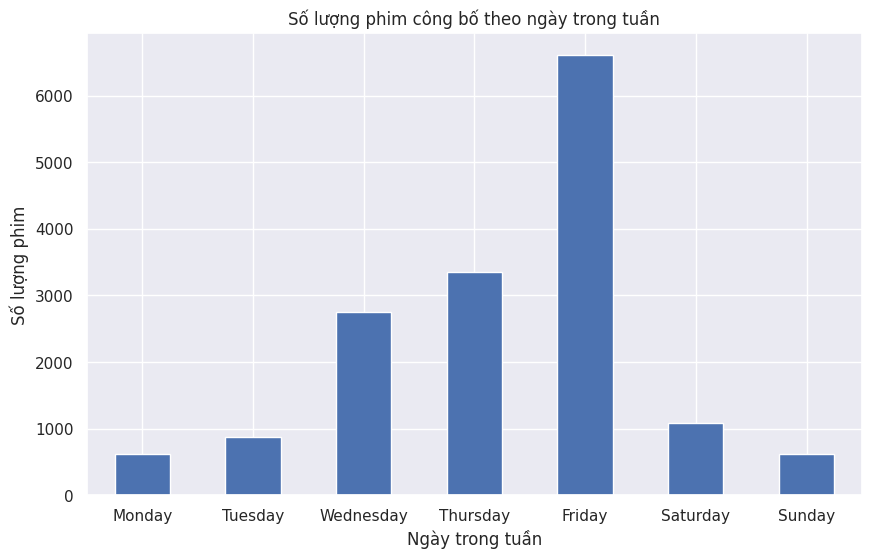

In [60]:
# Trích xuất ngày trong tuần (0: Monday, 1: Tuesday, ..., 6: Sunday)
df_rate['release_weekday'] = df_rate['release_date'].dt.weekday

# Vẽ biểu đồ số lượng phim theo ngày trong tuần
plt.figure(figsize=(10, 6))
df_rate['release_weekday'].value_counts().sort_index().plot(kind='bar')
plt.title('Số lượng phim công bố theo ngày trong tuần')
plt.xlabel('Ngày trong tuần')
plt.ylabel('Số lượng phim')

# Chỉnh tên các ngày trong tuần
plt.xticks(ticks=range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)
plt.xticks(rotation=0)
plt.show()

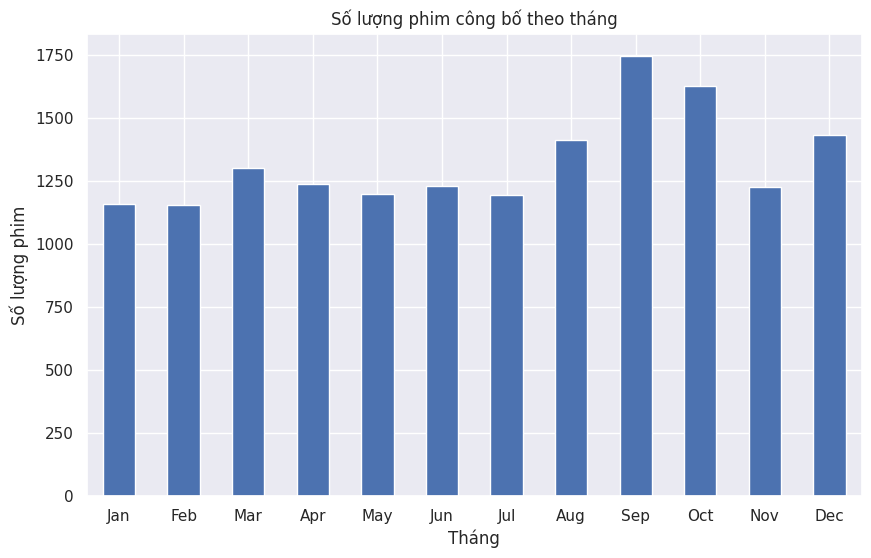

In [61]:
# Trích xuất tháng từ release_date
df_rate['release_month'] = df_rate['release_date'].dt.month

# Vẽ biểu đồ phân bố số lượng phim theo tháng
plt.figure(figsize=(10, 6))
df_rate['release_month'].value_counts().sort_index().plot(kind='bar')
plt.title('Số lượng phim công bố theo tháng')
plt.xlabel('Tháng')
plt.ylabel('Số lượng phim')

# Chỉnh lại tên các tháng
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.xticks(rotation=0)
plt.show()

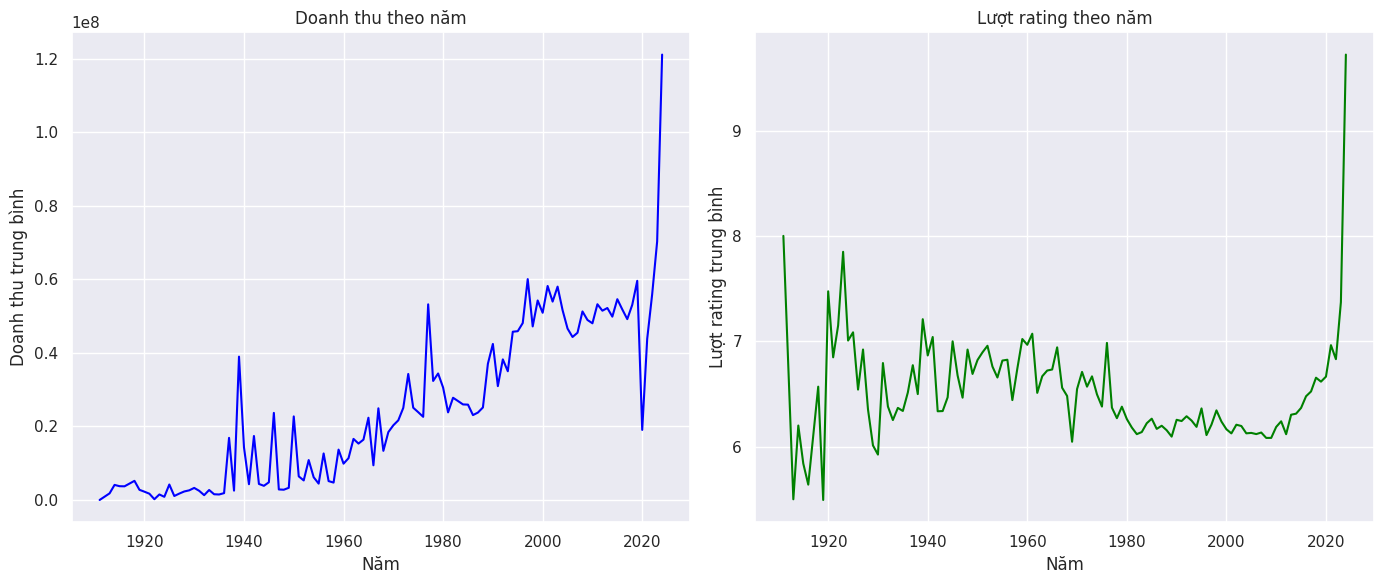

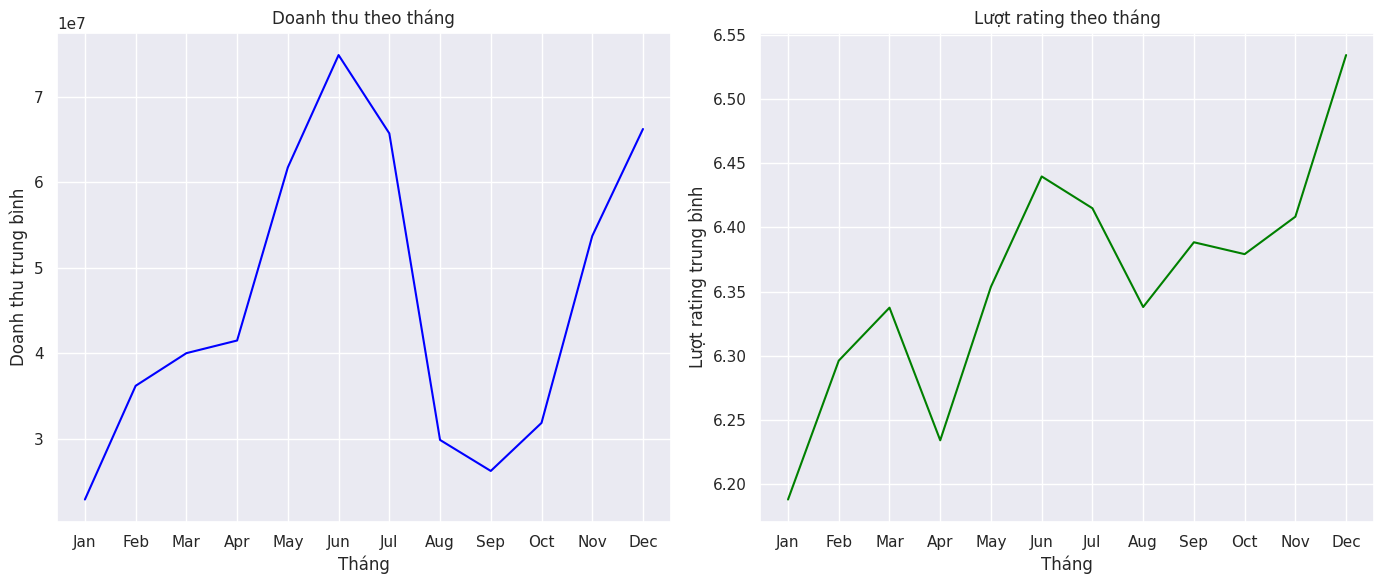

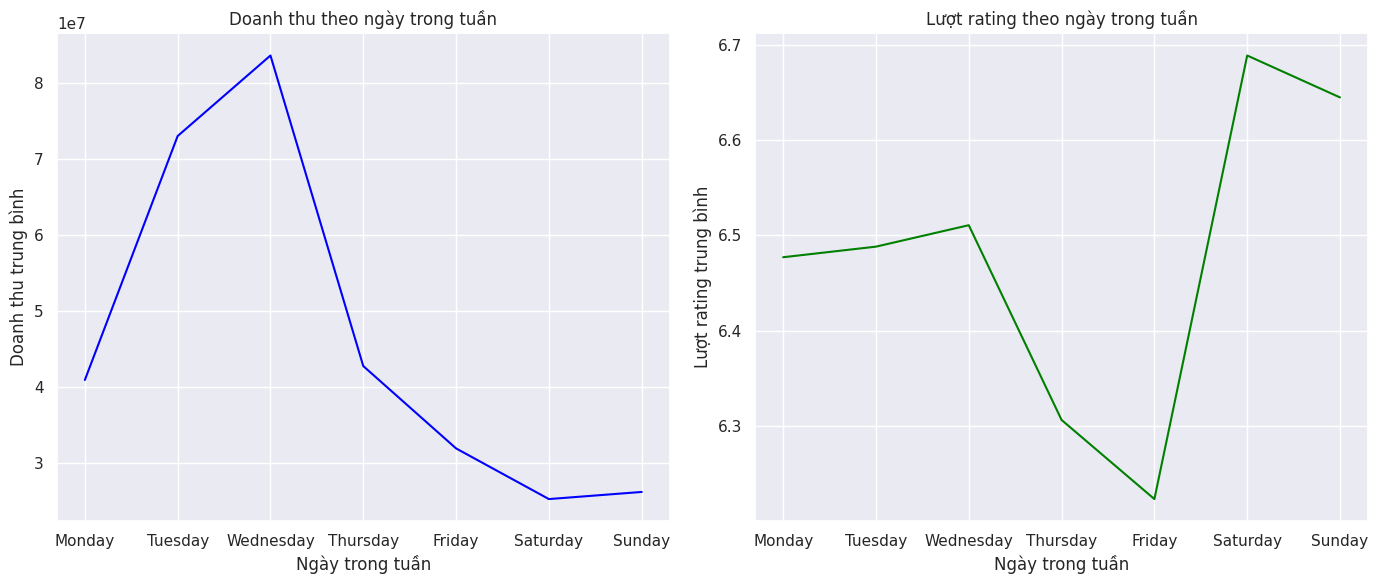

In [62]:
# 1. Doanh thu và lượt rating theo năm
revenue_by_year = df_rate.groupby('release_year')[['revenue', 'vote_average']].mean()

# 2. Doanh thu và lượt rating theo tháng (đảm bảo đủ tháng)
revenue_by_month = df_rate.groupby('release_month')[['revenue', 'vote_average']].mean()

# Đảm bảo rằng tất cả các tháng từ 1 đến 12 đều xuất hiện
revenue_by_month = revenue_by_month.reindex(range(1, 13), fill_value=0)

# 3. Doanh thu và lượt rating theo ngày trong tuần (đảm bảo đủ ngày trong tuần)
revenue_by_day_of_week = df_rate.groupby('release_weekday')[['revenue', 'vote_average']].mean()

# Đảm bảo rằng tất cả các ngày trong tuần từ 0 đến 6 đều xuất hiện
revenue_by_day_of_week = revenue_by_day_of_week.reindex(range(7), fill_value=0)

# Định nghĩa nhãn cho ngày trong tuần và tháng
day_of_week_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plot biểu đồ Doanh thu và lượt rating theo năm
plt.figure(figsize=(14, 6))

# Subplot cho Doanh thu theo năm
plt.subplot(1, 2, 1)
plt.plot(revenue_by_year.index, revenue_by_year['revenue'], label='Doanh thu', color='blue')
plt.title('Doanh thu theo năm')
plt.xlabel('Năm')
plt.ylabel('Doanh thu trung bình')
plt.grid(True)

# Subplot cho Lượt rating theo năm
plt.subplot(1, 2, 2)
plt.plot(revenue_by_year.index, revenue_by_year['vote_average'], label='Lượt rating', color='green')
plt.title('Lượt rating theo năm')
plt.xlabel('Năm')
plt.ylabel('Lượt rating trung bình')
plt.grid(True)

plt.tight_layout()
plt.show()
plt.figure(figsize=(14, 6))  # Tăng kích thước biểu đồ

# Subplot cho Doanh thu theo tháng
plt.subplot(1, 2, 1)
plt.plot(revenue_by_month.index, revenue_by_month['revenue'], label='Doanh thu', color='blue')
plt.title('Doanh thu theo tháng')
plt.xlabel('Tháng')
plt.ylabel('Doanh thu trung bình')
plt.xticks(revenue_by_month.index, month_labels, rotation=45)  # Điều chỉnh nhãn trục x
plt.xticks(rotation=0)
plt.grid(True)

# Subplot cho Lượt rating theo tháng
plt.subplot(1, 2, 2)
plt.plot(revenue_by_month.index, revenue_by_month['vote_average'], label='Lượt rating', color='green')
plt.title('Lượt rating theo tháng')
plt.xlabel('Tháng')
plt.ylabel('Lượt rating trung bình')
plt.xticks(revenue_by_month.index, month_labels, rotation=45)  # Điều chỉnh nhãn trục x
plt.xticks(rotation=0)
plt.grid(True)

# Điều chỉnh khoảng cách giữa các biểu đồ
plt.subplots_adjust(wspace=0.3)  # Tăng khoảng cách giữa các subplots
plt.tight_layout()  # Cải thiện layout
plt.show()

# Plot biểu đồ Doanh thu và lượt rating theo ngày trong tuần
plt.figure(figsize=(14, 6))

# Subplot cho Doanh thu theo ngày trong tuần
plt.subplot(1, 2, 1)
plt.plot(revenue_by_day_of_week.index, revenue_by_day_of_week['revenue'], label='Doanh thu', color='blue')
plt.title('Doanh thu theo ngày trong tuần')
plt.xlabel('Ngày trong tuần')
plt.ylabel('Doanh thu trung bình')
plt.xticks(revenue_by_day_of_week.index, day_of_week_labels, rotation=45)
plt.xticks(rotation=0)
plt.grid(True)

# Subplot cho Lượt rating theo ngày trong tuần
plt.subplot(1, 2, 2)
plt.plot(revenue_by_day_of_week.index, revenue_by_day_of_week['vote_average'], label='Lượt rating', color='green')
plt.title('Lượt rating theo ngày trong tuần')
plt.xlabel('Ngày trong tuần')
plt.ylabel('Lượt rating trung bình')
plt.xticks(revenue_by_day_of_week.index, day_of_week_labels, rotation=45)
plt.xticks(rotation=0)
plt.grid(True)

plt.tight_layout()
plt.show()

In [63]:
# Hàm chuyển năm thành thập kỷ
def convert_decade(x):
    try:
        return str(int(str(x)[:4]) // 10) + '0s'
    except:
        return None

# Áp dụng hàm cho cột release_year để tạo cột release_decade
df_rate['release_decade'] = df_rate['release_year'].apply(convert_decade)

print(df_rate[['release_year', 'release_decade']].head())

   release_year release_decade
0          2010          2010s
1          2014          2010s
2          2008          2000s
3          2009          2000s
4          2012          2010s


In [64]:
# Hàm chuyển tháng thành mùa
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'

# Áp dụng hàm cho cột release_date để tạo cột season
df_rate['season'] = df_rate['release_date'].dt.month.apply(get_season)

print(df_rate[['release_date', 'season']].head())

  release_date  season
0   2010-07-15  Summer
1   2014-11-05    Fall
2   2008-07-16  Summer
3   2009-12-15  Winter
4   2012-04-25  Spring


In [65]:
df_rate['release_weekday'] = df_rate['release_weekday'].map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday',
                                                            3: 'Thursday', 4: 'Friday', 5: 'Saturday',
                                                            6: 'Sunday'})

df_rate = pd.get_dummies(df_rate, columns=['release_weekday'], prefix='release', drop_first=False)

df_rate['release_decade'] = (df_rate['release_date'].dt.year // 10) * 10
df_rate['release_decade'] = df_rate['release_decade'].astype(str) + 's'

df_rate = pd.get_dummies(df_rate, columns=['release_decade'], prefix='release', drop_first=False)

df_rate = pd.get_dummies(df_rate, columns=['season'], prefix='season', drop_first=False)

df_rate = df_rate.drop(columns=['release_date'])

columns_to_convert = [col for col in df_rate.columns if 'release_' in col or 'season_' in col]
df_rate[columns_to_convert] = df_rate[columns_to_convert].astype(int)

print(df_rate.head())

             title  vote_average  vote_count       revenue  runtime  adult  \
0        Inception         8.364       34495  8.255328e+08      148      0   
1     Interstellar         8.417       32571  7.017292e+08      169      0   
2  The Dark Knight         8.512       30619  1.004558e+09      152      0   
3           Avatar         7.573       29815  2.923706e+09      162      0   
4     The Avengers         7.710       29166  1.518816e+09      143      0   

  original_language  popularity                      production_countries  \
0                en      83.952  United Kingdom, United States of America   
1                en     140.241  United Kingdom, United States of America   
2                en     130.643  United Kingdom, United States of America   
3                en      79.932  United States of America, United Kingdom   
4                en      98.082                  United States of America   

                     spoken_languages  ...  release_1970s release_19

## genres_list

In [66]:
df_rate['genres_list'].head()

,genres_list
0,"['Action', 'Science Fiction', 'Adventure']"
1,"['Adventure', 'Drama', 'Science Fiction']"
2,"['Drama', 'Action', 'Crime', 'Thriller']"
3,"['Action', 'Adventure', 'Fantasy', 'Science Fi..."
4,"['Science Fiction', 'Action', 'Adventure']"


In [67]:
df_rate['genres_list'].isnull().sum()

0

In [68]:
df_rate['num_genres_list'] = df_rate.genres_list.apply(lambda x: len(x) if x[0] != '' else 0)

In [69]:
def vectorize_column(df, col_name, min_df=20):
    # Split the cleaned strings into lists of words.
    ll = df[col_name].fillna('none').str.split(', ').to_list()
    # Further clean and preprocess words in the lists.
    ll = [[
        j.rstrip(', ').strip(' ').replace('/', '_').replace('.', '_').replace('+', '_').replace(',', '_').replace('\'', '_').replace(' ', '_').replace('.', '_').replace('&', '_').replace('+', '_').replace('-', '_').replace('!', '_')
        for j in i
    ] for i in ll]
    ll1 = []
    for item in ll:
        if item != ['none']:
            ttt = ' '.join(item)
        else:
            ttt = 'none'
        ll1.append(ttt)

    # Use CountVectorizer to convert text data into numerical features.
    vectorizer = CountVectorizer(max_features=60, min_df=min_df, lowercase=False)
    vectorizer.fit(ll1)
    voc = vectorizer.vocabulary_
    voc_inv = {v: col_name + '_' + k for k, v in voc.items()}
    vector = vectorizer.transform(ll1)
    tt = pd.DataFrame(vector.toarray())
    tt = tt.rename(columns=voc_inv)
    df = pd.concat([df.reset_index(drop=True), tt.reset_index(drop=True)], axis=1).drop([col_name], axis=1)

    return df

df_rate = vectorize_column(df_rate, col_name='genres_list', min_df=200)

## Numerical Feature Transformation

In [70]:
df_rate = df_rate.dropna()

In [71]:
num_features = ['revenue', 'runtime', 'popularity','budget', 'num_genres_list', 'num_production_countries', 'num_spoken_languages', 'title_length']

In [72]:
# Áp dụng log transform, thêm 1 để tránh log(0)
for feature in num_features:
    df_rate[feature + '_log'] = np.log1p(df_rate[feature])

df_rate[[feature + '_log' for feature in num_features]].head()

,revenue_log,runtime_log,popularity_log,budget_log,num_genres_list_log,num_production_countries_log,num_spoken_languages_log,title_length_log
0,20.531540,5.003946,4.442086,18.890684,3.761200,1.098612,1.609438,2.302585
1,20.369058,5.135798,4.950468,18.921456,3.737670,1.098612,0.693147,2.564949
2,20.727814,5.030438,4.880094,19.035866,3.713572,1.098612,1.098612,2.772589
3,21.796118,5.093750,4.393609,19.283571,3.988984,1.098612,1.098612,1.945910
4,21.141197,4.969813,4.595948,19.209138,3.761200,0.693147,1.386294,2.564949


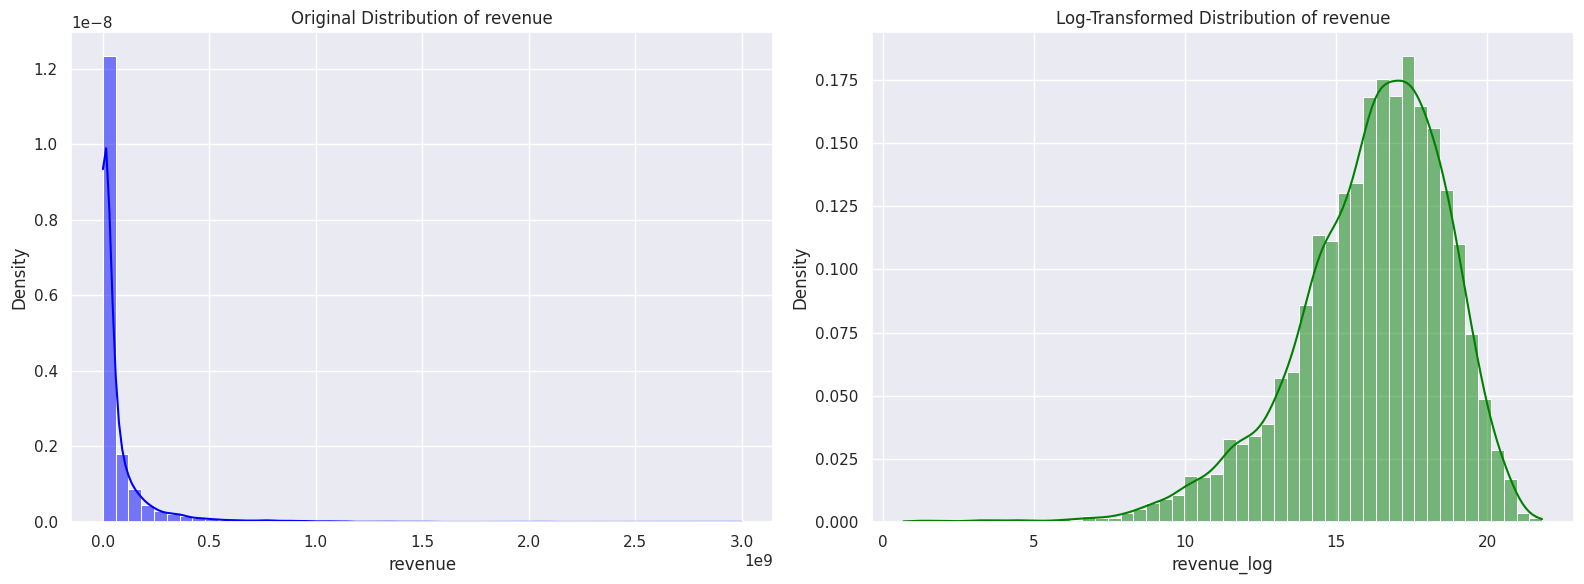

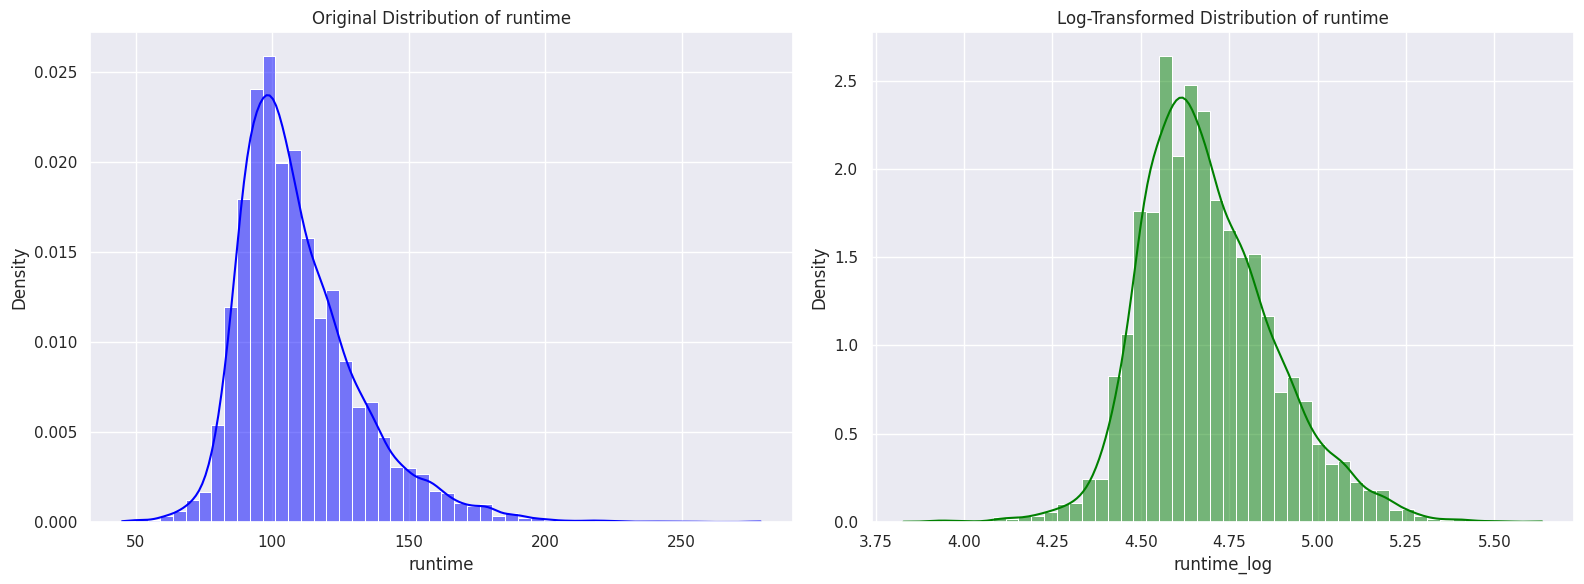

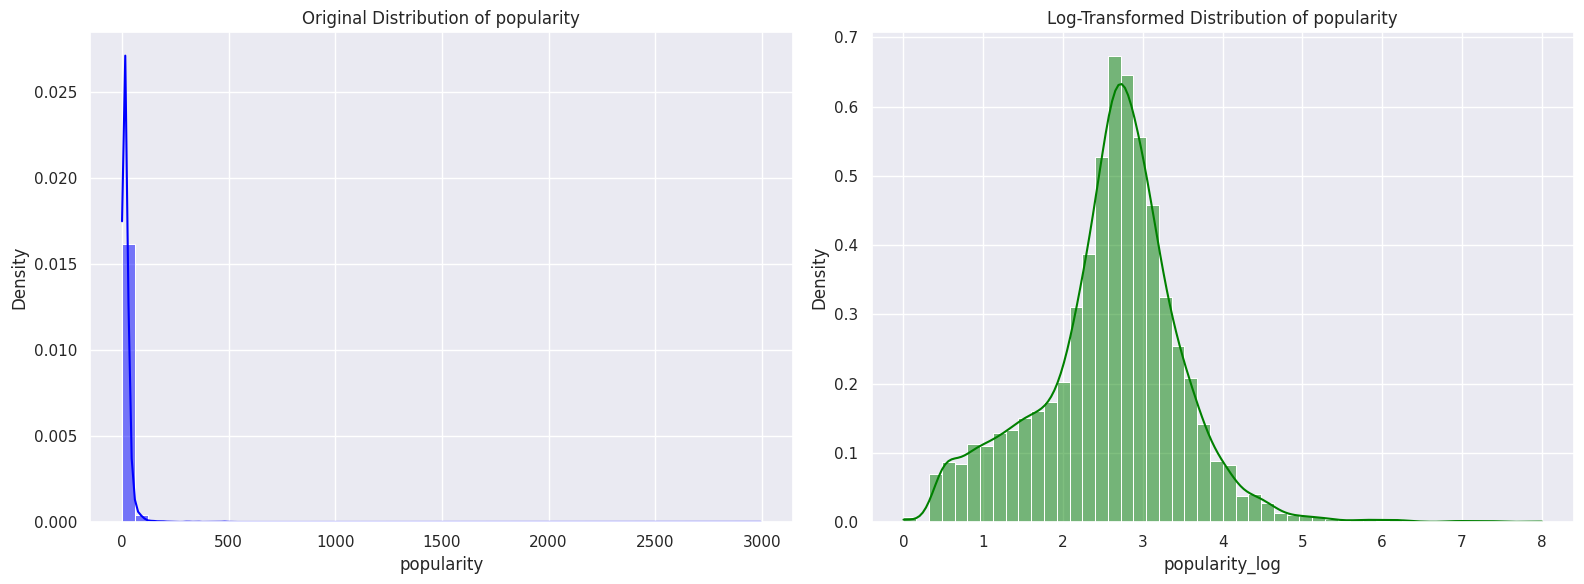

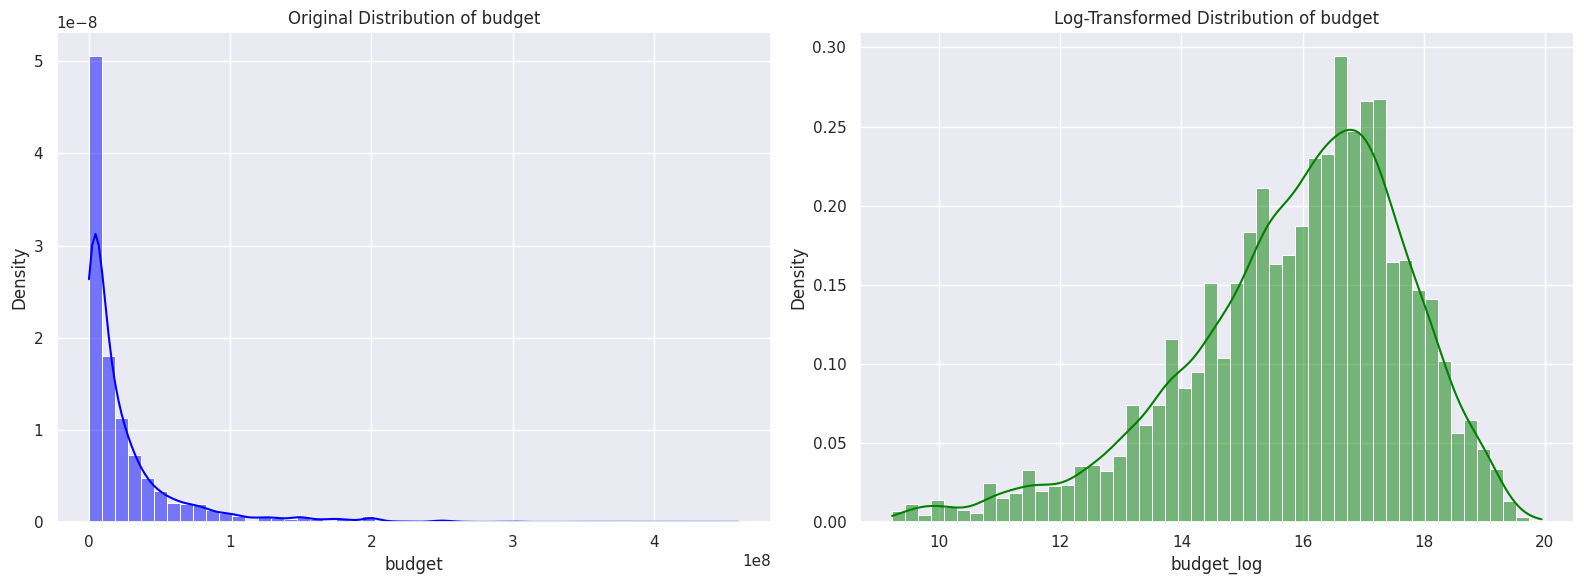

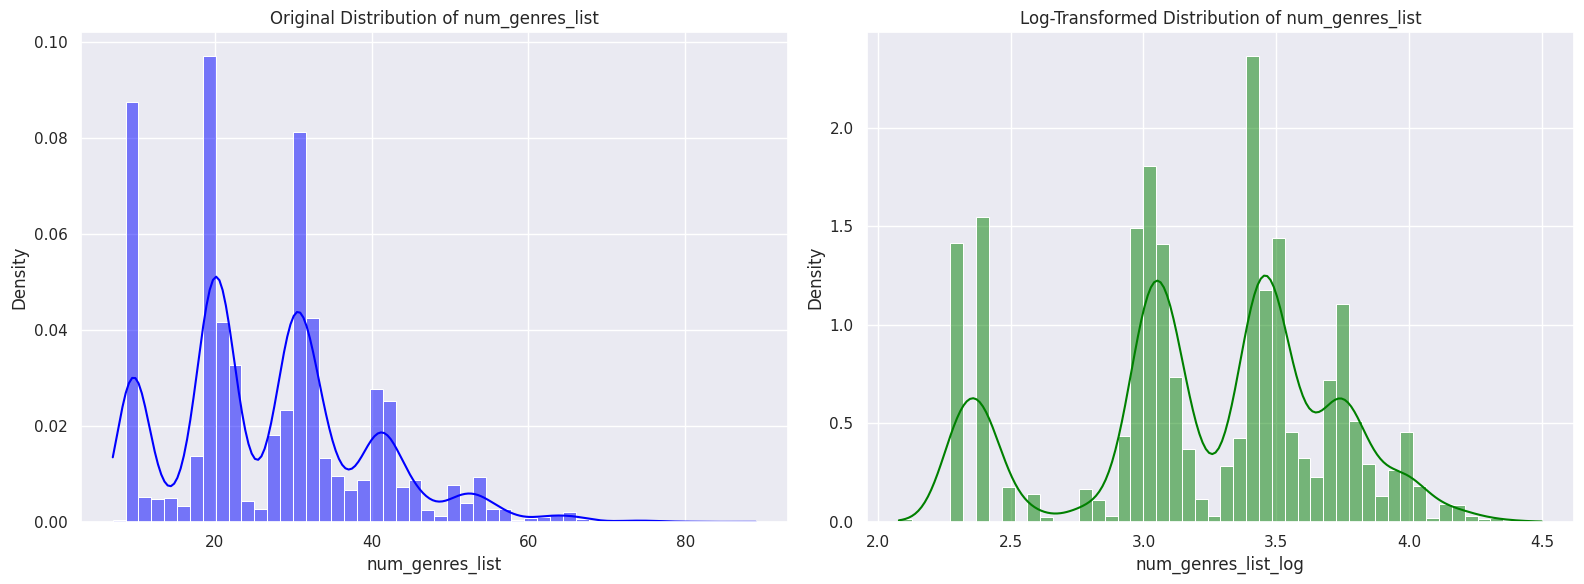

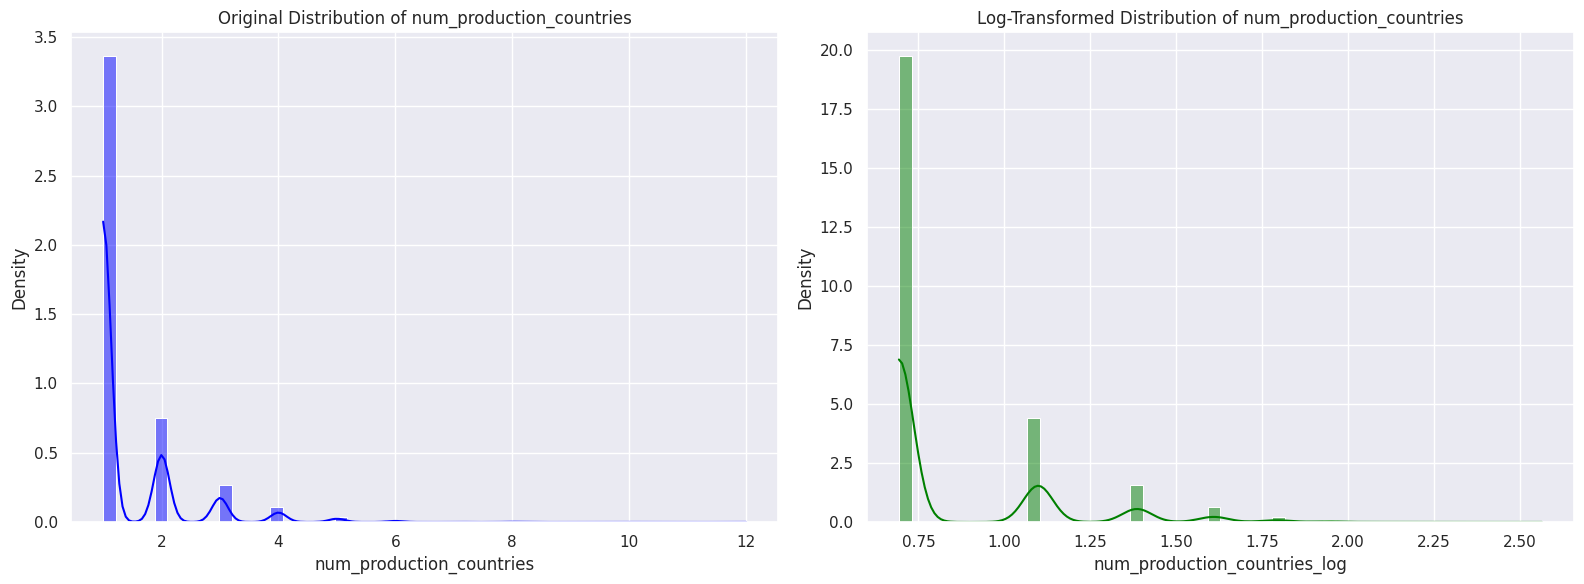

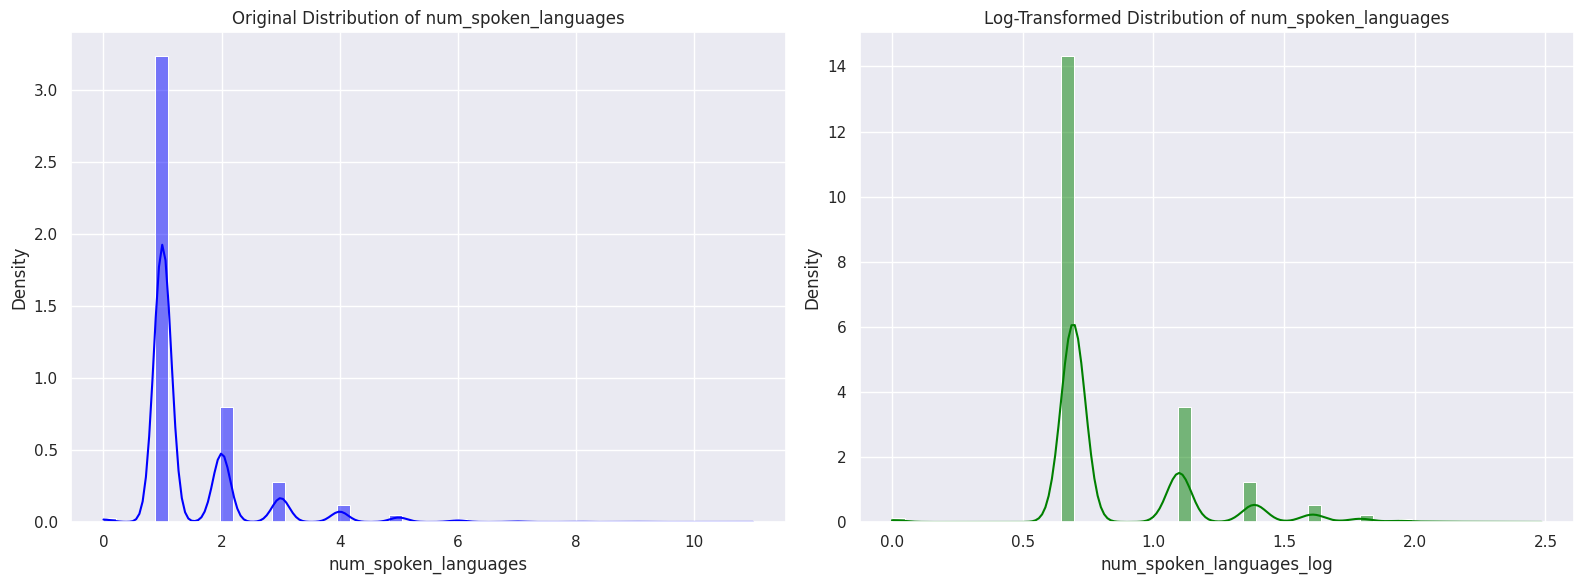

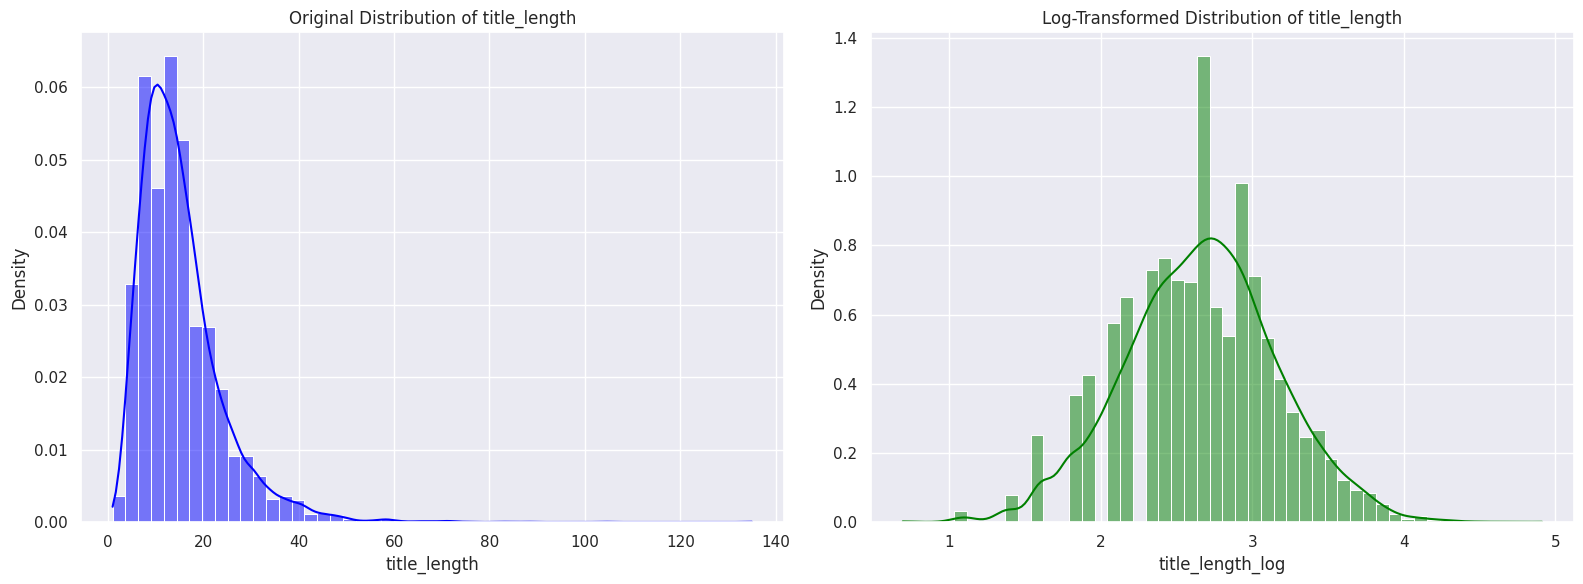

In [73]:
def plot_distribution(original_col, transformed_col, title):
    plt.figure(figsize=(16, 6))

    # Biểu đồ trước khi transform (Histogram + KDE)
    plt.subplot(1, 2, 1)
    sns.histplot(df_rate[original_col], bins=50, kde=True, color='blue', stat='density')
    plt.title(f'Original Distribution of {title}')
    plt.xlabel(original_col)
    plt.ylabel('Density')

    # Biểu đồ sau khi transform (Histogram + KDE)
    plt.subplot(1, 2, 2)
    sns.histplot(df_rate[transformed_col], bins=50, kde=True, color='green', stat='density')
    plt.title(f'Log-Transformed Distribution of {title}')
    plt.xlabel(transformed_col)
    plt.ylabel('Density')

    plt.tight_layout()
    plt.show()

# Áp dụng cho từng cột trong num_features
for feature in num_features:
    plot_distribution(feature, feature + '_log', feature)

# Feature Selection

In [ ]:
df_rating = df_rate

In [ ]:
df_rate['vote_average'].describe()

,vote_average
count,9549.000000
mean,6.403829
std,1.014734
min,0.800000
25%,5.852000
50%,6.447000
75%,7.029000
max,10.000000


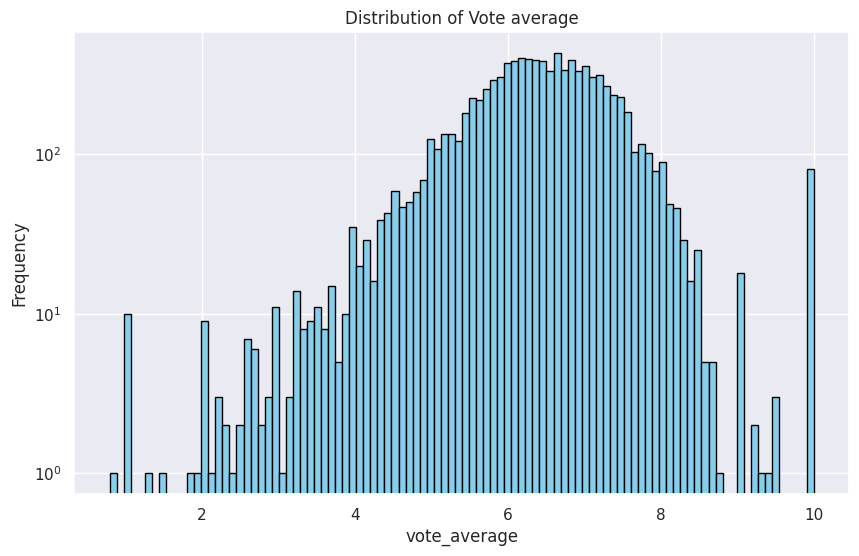

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df_rate['vote_average'], bins=100, color='skyblue', edgecolor='black')
plt.yscale('log')  # Set y-axis to log scale
plt.title('Distribution of Vote average')
plt.xlabel('vote_average')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Tính toán các thống kê cơ bản
mean = df_rating['vote_average'].mean()
median = df_rating['vote_average'].median()
min_val = df_rating['vote_average'].min()
max_val = df_rating['vote_average'].max()
std_dev = df_rating['vote_average'].std()

# Tính phân phối dữ liệu theo các nhóm
bins = [0, 4.999, 7.999, 10]
labels = ['Low', 'Average', 'Good']
df_rating['vote_average_category'] = pd.cut(df_rating['vote_average'], bins=bins, labels=labels)
distribution = df_rating['vote_average_category'].value_counts().sort_index()

# Biểu diễn kết quả dưới dạng văn bản
report = f"""
Phân phối của cột vote_average:
- Giá trị nhỏ nhất: {min_val}
- Giá trị lớn nhất: {max_val}
- Giá trị trung bình: {mean:.2f}
- Giá trị trung vị (median): {median}
- Độ lệch chuẩn (standard deviation): {std_dev:.2f}

Phân phối theo nhóm:
"""
for category, count in distribution.items():
    report += f"- {category}: {count} phim\n"

print(report)


Phân phối của cột vote_average:
- Giá trị nhỏ nhất: 0.8
- Giá trị lớn nhất: 10.0
- Giá trị trung bình: 6.40
- Giá trị trung vị (median): 6.447
- Độ lệch chuẩn (standard deviation): 1.01

Phân phối theo nhóm:
- Low: 647 phim
- Average: 8545 phim
- Good: 357 phim



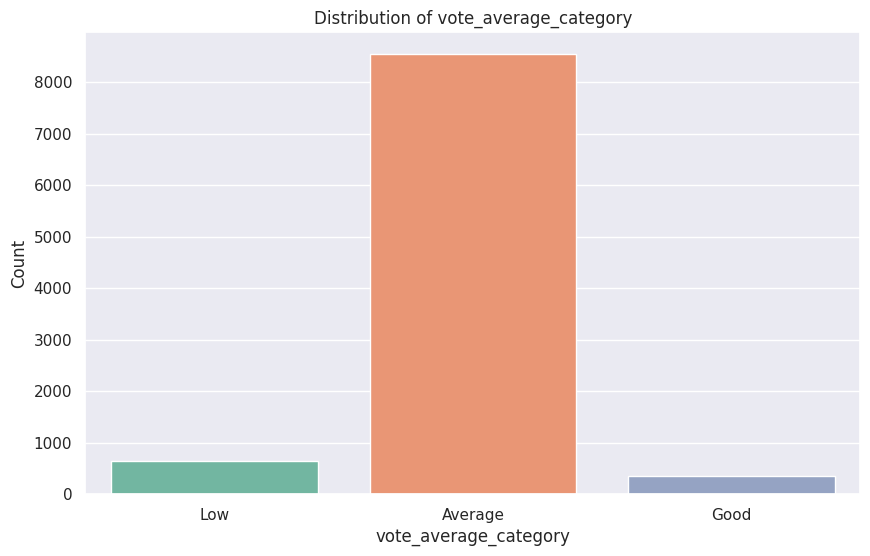

In [ ]:
plt.figure(figsize=(10, 6))
plot = sns.countplot(x='vote_average_category', data=df_rating, palette='Set2')
plt.title('Distribution of vote_average_category')
plt.xlabel('vote_average_category')
plt.ylabel('Count')
plt.show()

In [ ]:
columns_to_drop = [
    'title', 'original_language','production_countries', 'spoken_languages', 'release_year',
    'overview_sentiment', 're_production_countries', 're_spoken_languages', 'vote_average']

df_cleaned = df_rating.drop(columns=columns_to_drop)

df_cleaned['vote_average_category'] = df_cleaned['vote_average_category'].map({'Low': 0, 'Average': 1, 'Good': 2})
df_cleaned['vote_average_category'] = df_cleaned['vote_average_category'].astype(int)

In [ ]:
df_cleaned.head()

,vote_count,revenue,runtime,adult,popularity,title_length,budget,sentiment_cluster,num_production_countries,is_produced_in_US,...,revenue_log,runtime_log,popularity_log,budget_log,num_genres_list_log,num_production_countries_log,num_spoken_languages_log,title_length_log,Rating_category,vote_average_category
0,34495,8.255328e+08,148,0,83.952,9,160000000.0,2,2,1,...,20.531540,5.003946,4.442086,18.890684,3.761200,1.098612,1.609438,2.302585,Good,2
1,32571,7.017292e+08,169,0,140.241,12,165000000.0,2,2,1,...,20.369058,5.135798,4.950468,18.921456,3.737670,1.098612,0.693147,2.564949,Good,2
2,30619,1.004558e+09,152,0,130.643,15,185000000.0,2,2,1,...,20.727814,5.030438,4.880094,19.035866,3.713572,1.098612,1.098612,2.772589,Good,2
3,29815,2.923706e+09,162,0,79.932,6,237000000.0,2,2,1,...,21.796118,5.093750,4.393609,19.283571,3.988984,1.098612,1.098612,1.945910,Average,1
4,29166,1.518816e+09,143,0,98.082,12,220000000.0,2,1,1,...,21.141197,4.969813,4.595948,19.209138,3.761200,0.693147,1.386294,2.564949,Average,1


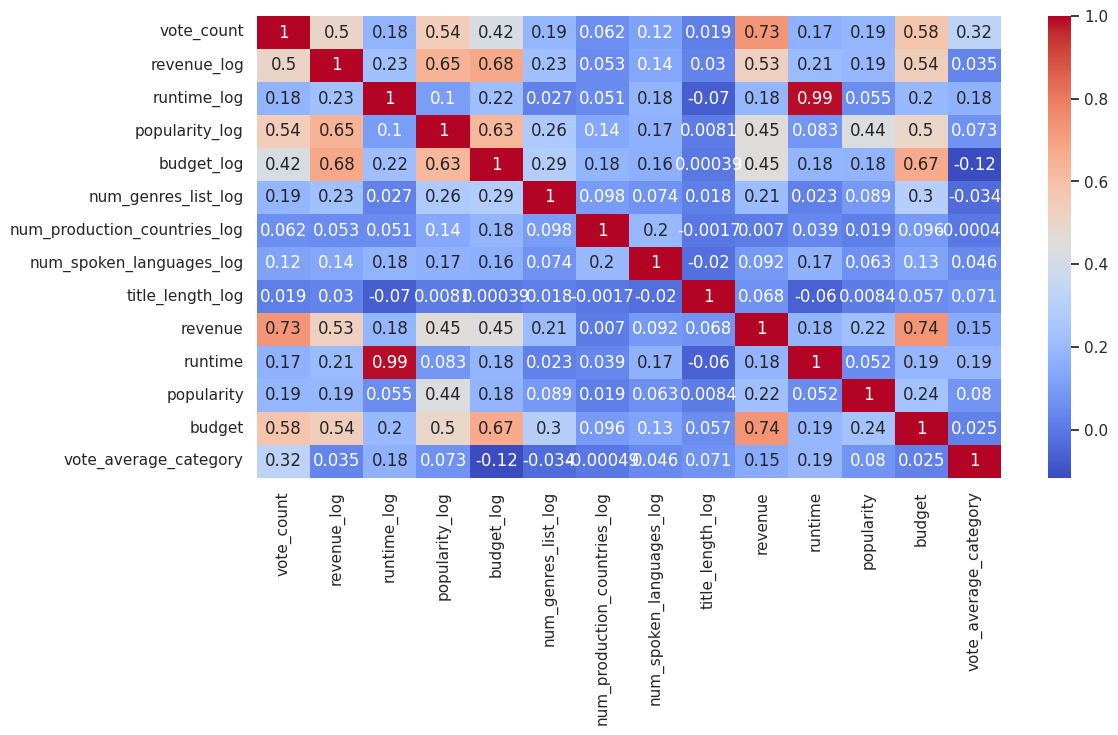

In [ ]:
numerical_features = ['vote_count', 'revenue_log', 'runtime_log', 'popularity_log', 'budget_log',
                      'num_genres_list_log', 'num_production_countries_log',
                      'num_spoken_languages_log', 'title_length_log', 'revenue', 'runtime', 'popularity', 'budget']

corr_matrix = df_cleaned[numerical_features + ['vote_average_category']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

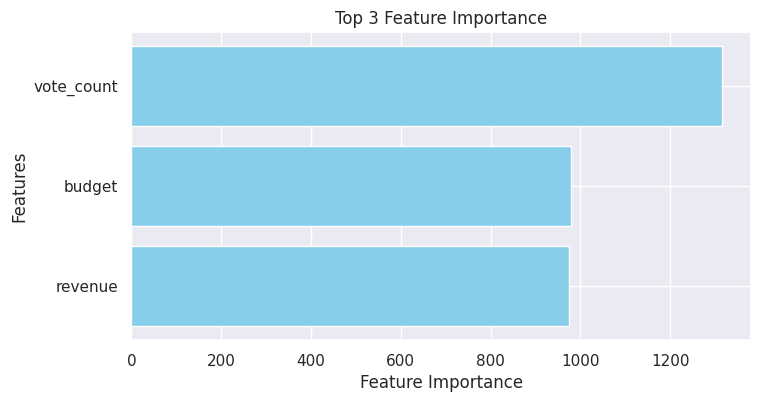

In [ ]:
X = df_cleaned.drop(columns=['vote_average_category'])
y = df_cleaned['vote_average_category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = lgb.LGBMClassifier(verbose=-1)
model.fit(X_train, y_train)

feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
top_3_features = feature_importance_df.head(3)

plt.figure(figsize=(8, 4))
plt.barh(top_3_features['Feature'], top_3_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 3 Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9549 entries, 0 to 15924
Data columns (total 67 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   vote_count                     9549 non-null   int64  
 1   revenue                        9549 non-null   float64
 2   runtime                        9549 non-null   int64  
 3   adult                          9549 non-null   int64  
 4   popularity                     9549 non-null   float64
 5   title_length                   9549 non-null   int64  
 6   budget                         9549 non-null   float64
 7   sentiment_cluster              9549 non-null   int32  
 8   num_production_countries       9549 non-null   int64  
 9   is_produced_in_US              9549 non-null   int64  
 10  num_spoken_languages           9549 non-null   int64  
 11  is_spoken_in_English           9549 non-null   int64  
 12  lang_en                        9549 non-null   int64